In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn import model_selection,preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

from iminuit import Minuit
import scipy
import scipy.integrate as integrate
from scipy.stats import norm
from scipy.special import erfinv
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.special import erfinv, erf

from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn import model_selection,preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

%matplotlib inline

2023-04-14 01:47:44.433924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Setup (20%)

Loading the 3 background and 1 signal datasets into pandas dataframes

In [2]:
Zjets = pd.read_csv("Zjets.csv",index_col=0)

In [3]:
Diboson = pd.read_csv("Diboson.csv",index_col=0)

In [4]:
Top = pd.read_csv("Top.csv",index_col=0)

In [5]:
ggH1000 = pd.read_csv("ggH1000.csv",index_col=0)

### Data sanity check

In [6]:
Zjets.head(5)

,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,fatjet_phi,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,-0.790471,177227.420,1,95697.766,64252.690,0.097862,1.895164,425871.88,-1.329446,-0.485957,...,1.782276,-1.057460,76128.370,12476.566,1,-0.289019,1.966965,11973.011,596020.44,-1.0
1,0.789204,10660.757,1,90289.914,32506.705,0.000000,0.000000,247948.36,-0.429050,2.770810,...,-0.918399,-1.229385,40799.945,38147.754,1,0.847265,0.995251,27624.867,260357.19,-1.0
2,-0.872639,655334.400,1,92994.430,55287.625,0.059006,2.463149,630492.94,-0.543789,-2.190247,...,-1.091297,0.865696,57988.660,29768.775,1,0.440004,-1.042492,27102.590,422698.44,-1.0
3,-0.772697,41489.973,1,89607.580,63405.484,0.265080,2.081222,610611.56,1.776149,-0.214862,...,1.238367,2.127853,55424.742,69817.470,1,0.809497,-2.276664,51873.030,302718.06,-1.0
4,1.581337,41731.630,1,90199.480,47187.332,0.093765,2.321676,781746.90,-1.524169,-1.101946,...,-0.116431,1.745413,68312.220,33509.810,1,0.598434,-1.972788,28290.979,461896.25,-1.0


In [7]:
Diboson.head(5)

,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,fatjet_phi,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,0.387345,41920.540,0,187549.810,374316.600,0.127114,1.786927,353161.47,-0.001591,1.914456,...,1.677279,-1.346853,369495.34,12147.315,1,-0.686657,-2.412152,9755.2705,1014320.10,-1.0
1,0.172328,225618.530,0,13106.807,51429.535,0.269517,2.296220,357617.66,-1.066937,-0.145452,...,-2.057147,2.975854,36972.74,34980.440,-1,-1.521354,2.819377,14584.7360,240295.97,-1.0
2,0.371392,42284.125,0,84519.230,153790.270,0.051175,3.360730,345472.30,0.704825,-2.816466,...,-0.285897,-0.084159,146895.95,24618.990,-1,0.741342,1.177780,19119.7030,471285.40,-1.0
3,0.309902,42735.938,1,76138.640,102611.836,0.117028,0.702838,476446.80,0.095546,1.012053,...,-0.160614,-2.544057,109699.72,22303.861,1,-1.648011,1.120479,8277.4480,495503.10,-1.0
4,0.202772,70475.780,0,86138.000,141886.280,0.053951,3.634348,799487.75,-1.828396,-2.406883,...,-0.499056,0.429884,151453.40,14053.401,-1,-0.171763,2.796952,13848.2230,498823.40,-1.0


In [8]:
Top.head(5)

,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,fatjet_phi,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,2.004522e-09,51609.760,1,35253.492,35612.324,0.109581,1.435712,461309.30,-1.195378,2.909157,...,0.164823,1.042927,38513.980,11072.072,1,-0.665443,-0.969063,9003.888,245723.92,-1.0
1,1.822626e-09,225038.800,1,20311.205,38644.793,0.090346,2.403266,276659.70,0.387434,3.050592,...,-1.871251,0.601309,34191.734,34626.312,1,-1.975266,1.798074,9425.637,351938.88,-1.0
2,1.552981e-09,27090.697,1,134715.500,244261.840,0.212569,1.336584,900965.50,-1.822714,-0.619062,...,0.701193,2.446600,254871.310,17551.730,-1,-0.196344,0.185058,17218.764,1046120.90,-1.0
3,1.660535e-09,57572.890,0,69086.836,90045.625,0.133918,1.780693,596016.20,-1.725750,-2.554189,...,-2.305750,0.627527,84608.050,10652.912,1,-0.413642,1.657720,9801.820,301995.70,-1.0
4,1.461494e-09,123177.900,0,51731.508,52780.684,0.101556,3.398984,590811.44,1.477704,1.432744,...,-0.685020,-2.360906,50720.953,15453.791,-1,0.880629,2.436030,10932.975,376986.28,-1.0


In [9]:
ggH1000.head(5)

,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,fatjet_phi,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,0.013603,44495.770,1,87475.55,627990.80,0.116438,0.889354,675246.25,-0.851387,2.042860,...,-0.906080,-1.876361,320104.62,495510.120,-1,-1.034808,-1.631069,312638.44,1063465.80,999999.56
1,0.242178,34441.156,1,90507.31,409780.94,0.191874,1.485706,604275.70,1.041311,-0.817613,...,2.363212,2.032987,288589.78,579769.560,1,2.178999,2.466579,129548.62,974210.75,1000003.60
2,0.096412,21625.379,0,89765.85,344668.30,0.122089,1.219367,612517.94,0.417858,-2.133300,...,1.217848,0.664946,228625.23,333899.970,-1,1.695172,0.920596,118590.28,996837.40,999999.80
3,0.096373,21855.973,1,92313.63,535629.06,0.061306,0.592705,482630.90,0.438590,2.701475,...,-0.045790,-0.626280,302502.84,243535.750,1,0.293053,-0.557273,233439.89,989655.56,1000008.80
4,0.073052,33677.380,1,89451.92,296257.47,0.159334,0.724910,459737.80,1.213717,-0.926707,...,-1.289961,2.238501,224785.02,98477.516,-1,-0.747040,2.647597,76205.98,993398.30,1000011.90


All data loaded well

### Check need for data cleaning

In [10]:
np.isnan(Zjets).sum().sum()

0

In [11]:
np.isnan(Diboson).sum().sum()

0

In [12]:
np.isnan(Top).sum().sum()

0

In [13]:
np.isnan(ggH1000).sum().sum()

0

Data is clean

### 1D normalised distributions for the first 9 variables listed in Table 1, with one plot per variable and the distributions categorised by physics process

In [14]:
var_names = np.array(["lep1_pt","lep2_pt","fatjet_pt","fatjet_eta","fatjet_D2","Zll_mass","Zll_pt","MET","reco_zv_mass"])

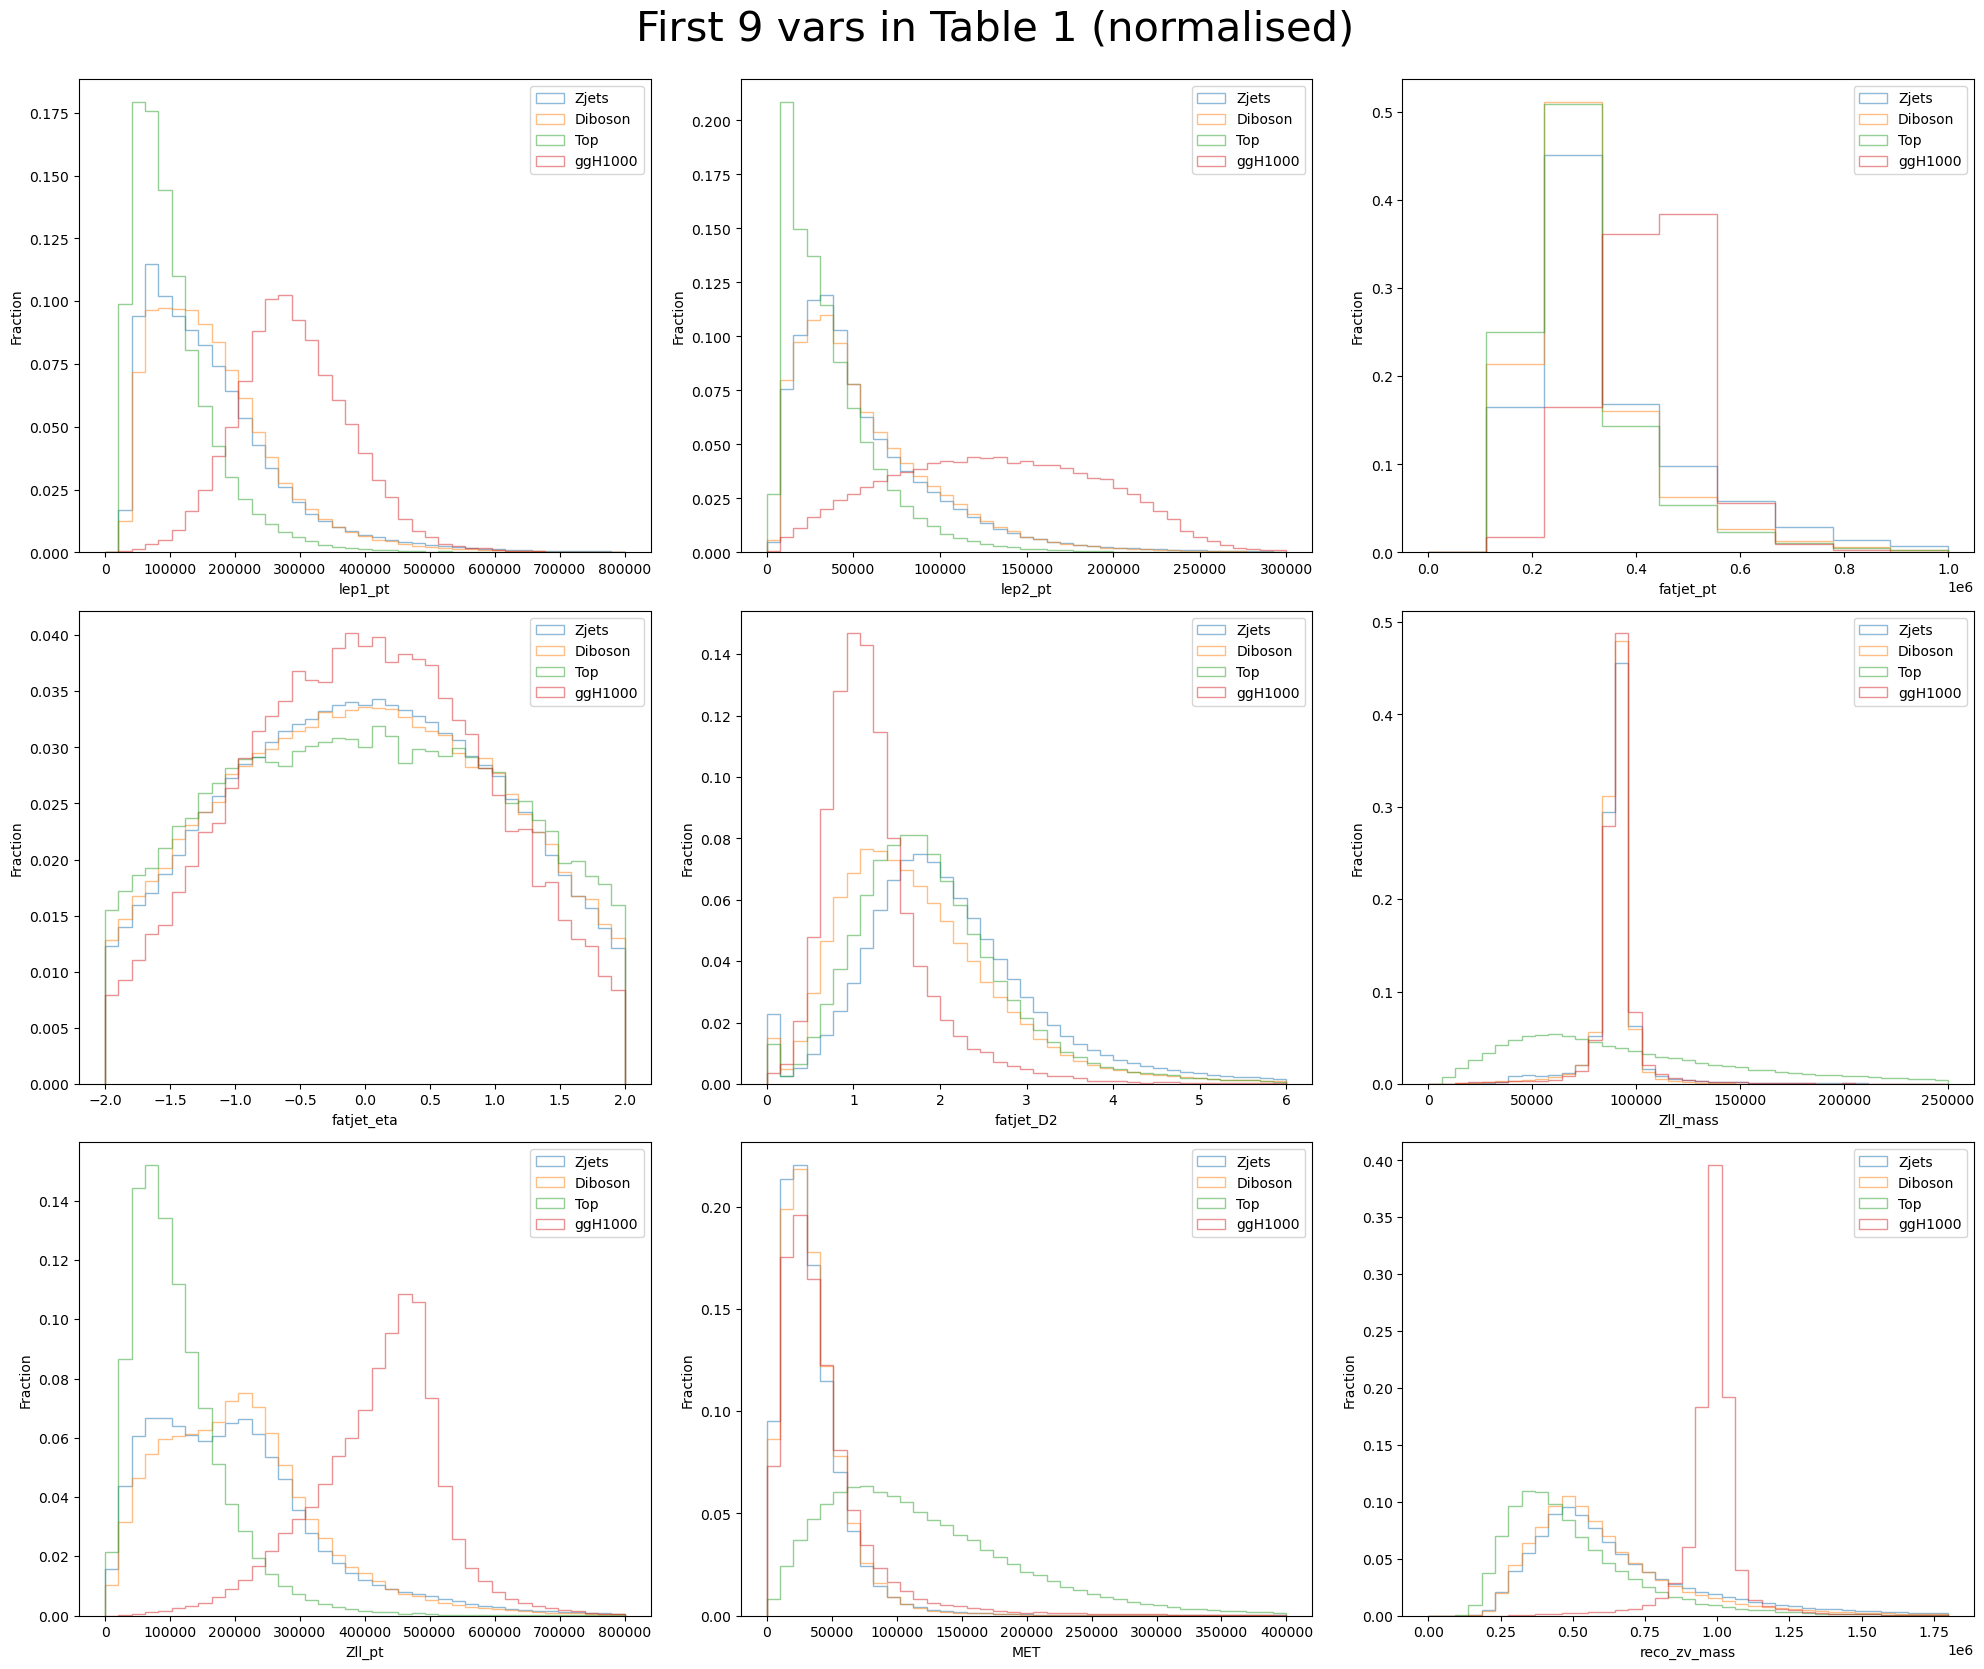

In [15]:
plt.figure(figsize=(20,80))

bins = [np.linspace(0,0.8e6,40),np.linspace(0,0.3e6,40),np.linspace(0,1e6,10),np.linspace(-2,2,40),
        np.linspace(0,6,40),np.linspace(0,0.25e6,40),np.linspace(0,0.8e6,40),np.linspace(0,0.4e6,40),
        np.linspace(0,1.8e6,40)]

for i, var in enumerate(var_names):
    ax = plt.subplot(15,3,i+1)
    # Plotting each physics process separately for each variable
    for j in [Zjets[var],Diboson[var],Top[var],ggH1000[var]]:
        
        # Calculating weights to normalise each of the distributions
        non_zero = np.count_nonzero(~np.isnan(j))
        weights = np.ones_like(j)/float(non_zero)
        plt.hist(j,alpha=0.5,bins=bins[i],weights=weights,histtype="step")

    plt.xlabel(var)
    plt.ylabel("Fraction")
    plt.legend(["Zjets","Diboson","Top","ggH1000"])        
    
plt.suptitle("First 9 vars in Table 1 (normalised)",y=1,size=30)    
plt.tight_layout()
plt.show()

The distributions of the individual datasets look reasonable which confirms that they have been loaded well. We can now proceed to group all of the background physics processes into a single distribution for each variable.

### 1D distributions for the first 9 variables listed in Table 1, background combined.

Combining the background distributions

In [16]:
background = pd.concat([Zjets,Diboson,Top],ignore_index=True)

In [17]:
background.reset_index(drop=True, inplace=True)

In [18]:
background.head(5)

,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,fatjet_phi,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,-0.790471,177227.420,1,95697.766,64252.690,0.097862,1.895164,425871.88,-1.329446,-0.485957,...,1.782276,-1.057460,76128.370,12476.566,1,-0.289019,1.966965,11973.011,596020.44,-1.0
1,0.789204,10660.757,1,90289.914,32506.705,0.000000,0.000000,247948.36,-0.429050,2.770810,...,-0.918399,-1.229385,40799.945,38147.754,1,0.847265,0.995251,27624.867,260357.19,-1.0
2,-0.872639,655334.400,1,92994.430,55287.625,0.059006,2.463149,630492.94,-0.543789,-2.190247,...,-1.091297,0.865696,57988.660,29768.775,1,0.440004,-1.042492,27102.590,422698.44,-1.0
3,-0.772697,41489.973,1,89607.580,63405.484,0.265080,2.081222,610611.56,1.776149,-0.214862,...,1.238367,2.127853,55424.742,69817.470,1,0.809497,-2.276664,51873.030,302718.06,-1.0
4,1.581337,41731.630,1,90199.480,47187.332,0.093765,2.321676,781746.90,-1.524169,-1.101946,...,-0.116431,1.745413,68312.220,33509.810,1,0.598434,-1.972788,28290.979,461896.25,-1.0


Looks good.

In [19]:
signal = ggH1000

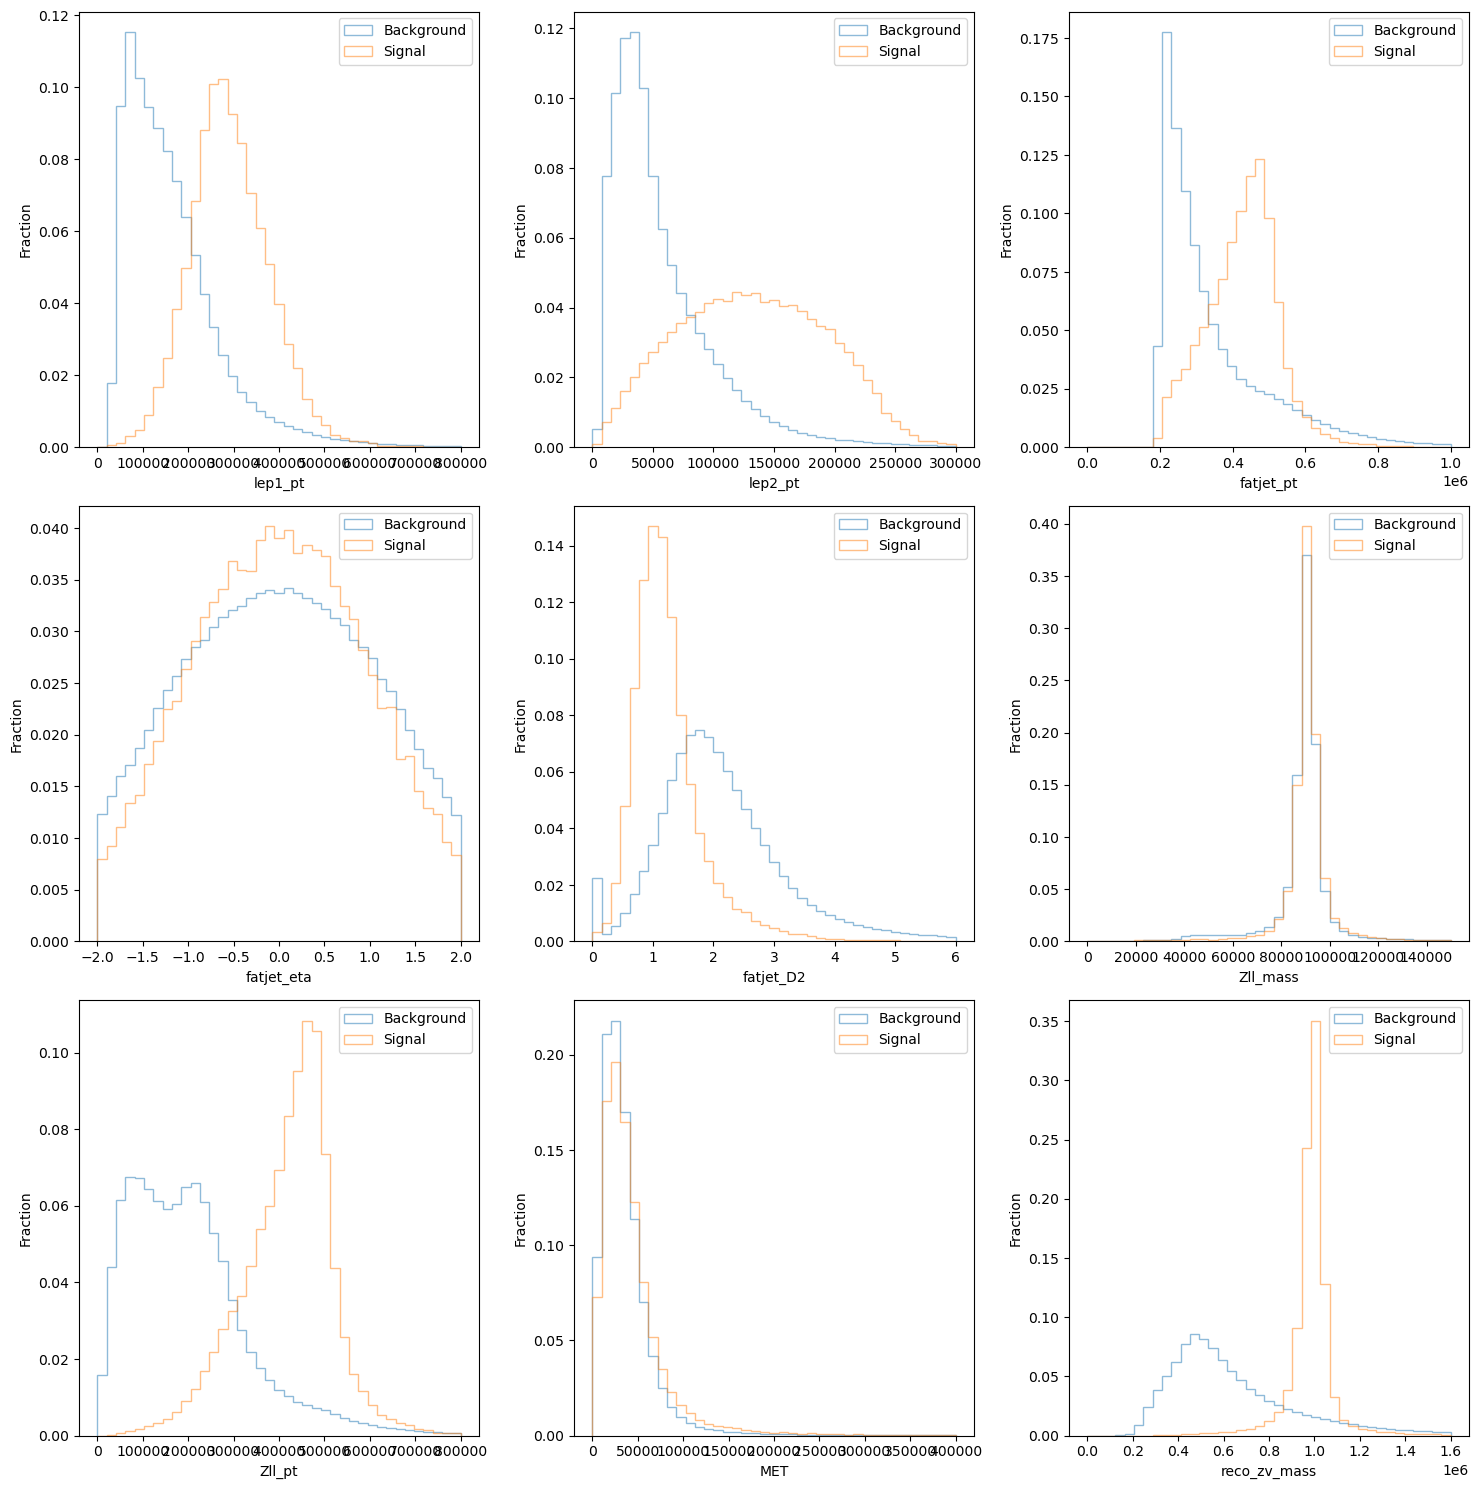

In [20]:
plt.figure(figsize=(15,15))

bins = [np.linspace(0,0.8e6,40),np.linspace(0,0.3e6,40),np.linspace(0,1e6,40),np.linspace(-2,2,40),
        np.linspace(0,6,40),np.linspace(0,0.15e6,40),np.linspace(0,0.8e6,40),np.linspace(0,0.4e6,40),
        np.linspace(0,1.6e6,40)]

for i, var in enumerate(var_names):
    ax = plt.subplot(3,3,i+1)
    # Plotting the background and signal separately
    for j in [background, signal]:
        
        # Calculating weights to normalise each of the distributions
        non_zero = np.count_nonzero(~np.isnan(j[var]))
        weights = np.ones_like(j[var])/float(non_zero)
        plt.hist(j[var],alpha=0.5,bins=bins[i],weights=weights,histtype="step")

    plt.xlabel(var)
    plt.ylabel("Fraction")
    plt.legend(["Background","Signal"])        
    
plt.tight_layout()
plt.show()

We can now use these distributions to pick good square cuts on variables to effectively remove the background while retaining as much signal as possible.

In [21]:
combined = pd.concat([signal,background],ignore_index=True)
combined.reset_index(drop=True, inplace=True)

We make sure not to shuffle the events at this point so that they can easily be plotted with the correct weights.

In [22]:
print("In total there are",combined.shape[0],"entries and",combined.shape[1],"variables in the combined dataset")

In total there are 6876972 entries and 24 variables in the combined dataset


The subset of variables that we will be considering for this analysis.

In [23]:
combined[var_names]

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass
0,320104.62,312638.440,480641.84,-0.851387,0.889354,87475.550,627990.800,44495.770,1063465.80
1,288589.78,129548.620,375352.78,1.041311,1.485706,90507.310,409780.940,34441.156,974210.75
2,228625.23,118590.280,555879.20,0.417858,1.219367,89765.850,344668.300,21625.379,996837.40
3,302502.84,233439.890,430646.20,0.438590,0.592705,92313.630,535629.060,21855.973,989655.56
4,224785.02,76205.980,244348.40,1.213717,0.724910,89451.920,296257.470,33677.380,993398.30
...,...,...,...,...,...,...,...,...,...
6876967,189162.12,173680.230,801905.90,-0.246266,2.365183,242512.390,283429.380,210689.080,1249612.90
6876968,55554.82,13437.131,228148.72,-1.257358,1.479040,56229.780,49418.700,49457.887,448721.70
6876969,58784.18,18757.412,251717.31,-0.813268,1.315544,64875.945,63561.215,135138.220,289546.44
6876970,155708.28,33805.680,273688.03,0.582633,0.729468,136088.280,145919.600,120977.230,478745.75


Plotting the correlations of variables with reco_zv_mass. The correlation between the variables and reco_zv_mass is calculated for each variable for the background events. 


<!-- <b>Takes a few minutes to plot.</b> -->

<!-- Making cuts in background variables with high reco_zv_mass causes sculpting of the background, where the background is shaped to look more like signal in the reco_zv_mass distribution. Therefore, we want to avoid making large cuts in highly correlated variables. -->

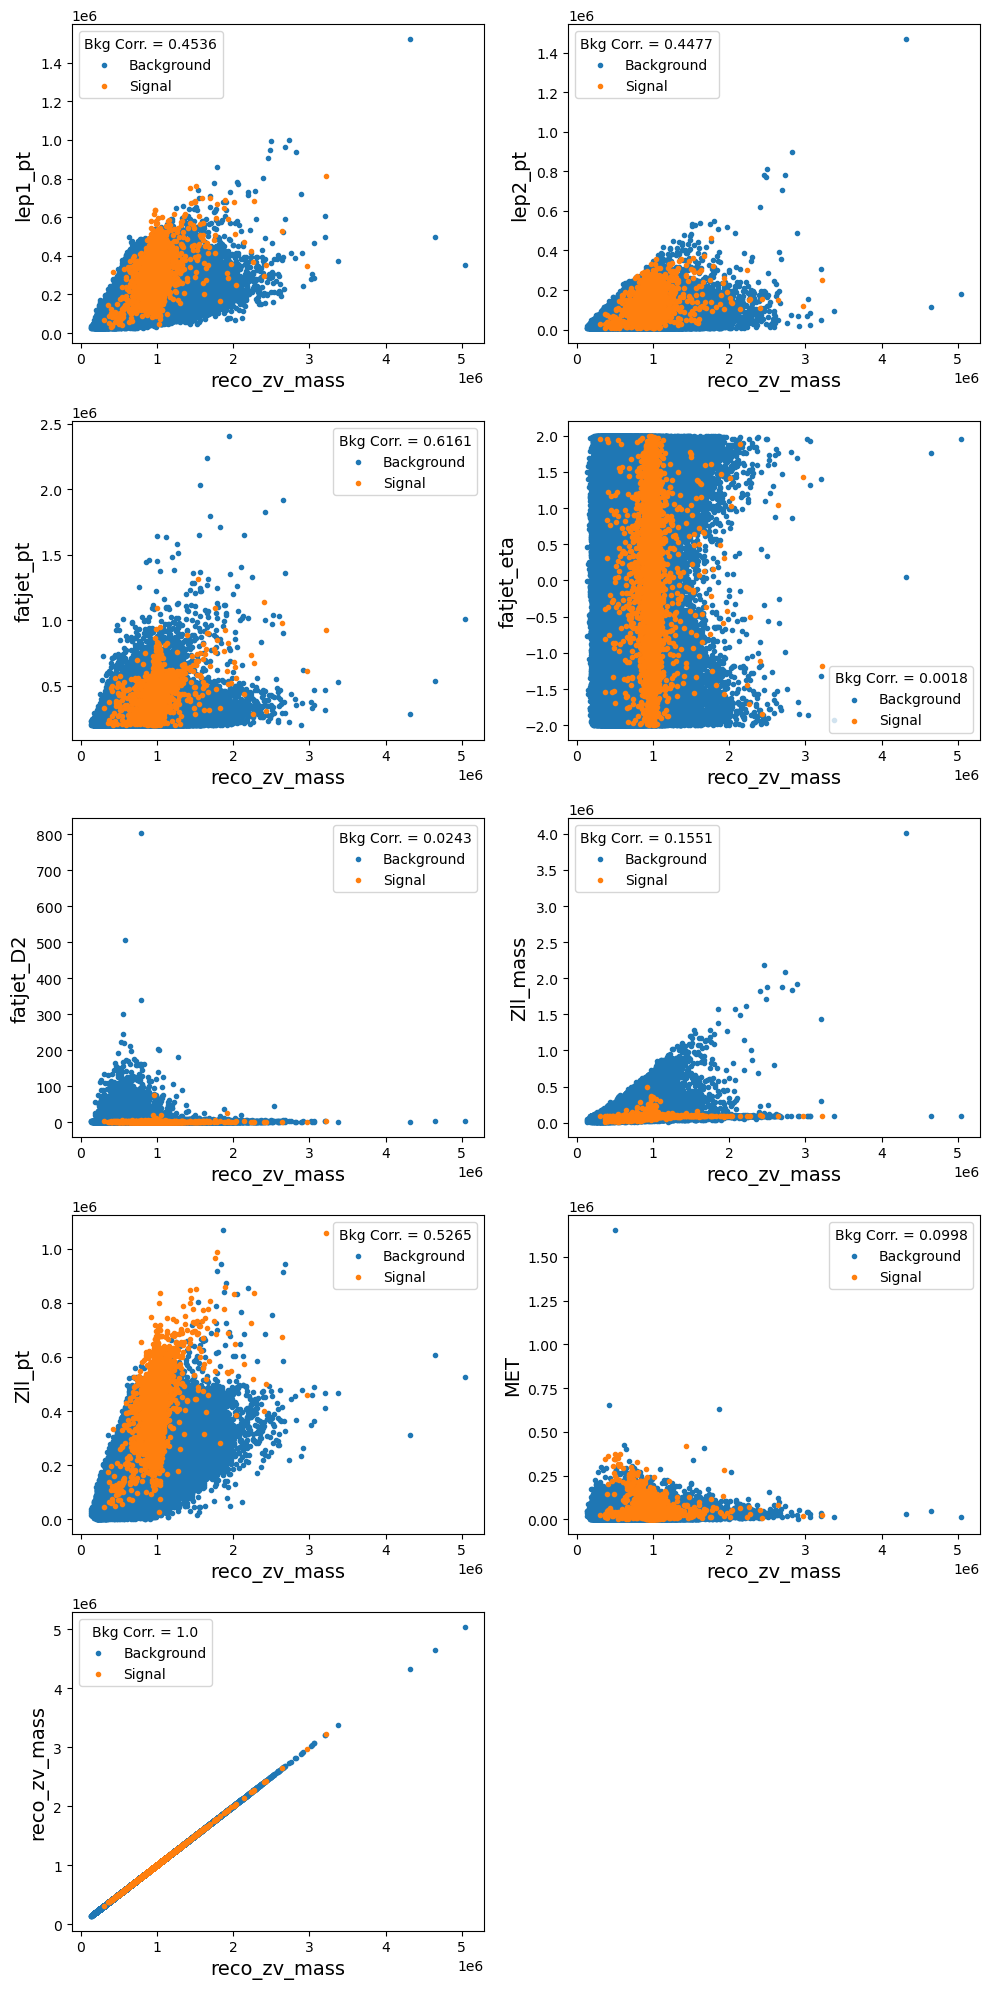

In [24]:
plt.figure(figsize=(10,20))
count = 1
for i, var1 in enumerate(var_names):
    ax = plt.subplot(5,2,count)
    count +=1
    # Plotting the background and signal separately
    for signal in [0,1]:
        mask = combined.isSignal == signal
        
        # Plotting only 10% of each dataset to save time
        plt.scatter(combined["reco_zv_mass"][mask].iloc[:int(mask.sum()*0.1)],
                    combined[var1][mask].iloc[:int(mask.sum()*0.1)], marker=".")
    
    # Determining the linear correlation between each variable and reco_zv_mass for the background
    corr = round(np.corrcoef(background["reco_zv_mass"],background[var1])[0,1],4)
    
    plt.xlabel("reco_zv_mass",fontsize=14)
    plt.ylabel(var_names[i],fontsize=14)
    plt.legend(["Background","Signal"],title="Bkg Corr. = "+str(corr),loc="best")       
    
plt.tight_layout()
plt.show()

Saving the correlation of variables with reco_zv_mass amongst background entries.

In [25]:
corrs = np.array([])
for var in var_names:
    corr = round(np.corrcoef(background["reco_zv_mass"],background[var])[0,1],4)
    corrs = np.append(corrs,corr)

Printing the correlation of background variables with reco_zv_mass in order of size.

In [26]:
for i in range(9):
    print(var_names[np.argsort(corrs)][i],":",corrs[np.argsort(corrs)][i])

fatjet_eta : 0.0018
fatjet_D2 : 0.0243
MET : 0.0998
Zll_mass : 0.1551
lep2_pt : 0.4477
lep1_pt : 0.4536
Zll_pt : 0.5265
fatjet_pt : 0.6161
reco_zv_mass : 1.0


We can see that variables such as <b>fatjet_pt</b> and <b>Zll_pt</b> are very highly correlated with <b>reco_zv_mass</b>, while variables such as <b>fatjet_eta</b> and <b>fatjet_D2</b> show very low correlation.

We want to avoid making cuts in variables where the background is highly correlated with the <b>reco_zv_mass</b> variable as this will distort (sculpt) the background distribution in the <b>reco_zv_mass</b> following the cut. We want to retain the shape of the background distribution so that we can make an accurate fit to confidently test out hypotheses.

<!-- We want to retain the shapes of each distribution so that we can make an accurate fit to confidently test our hypotheses. -->

<!-- We want to uniformly reduce background distribution across the range of the reco_zv_mass variable while retaining as much of the signal as possible during the selection cuts. This allows to achieve the lowest uncertainty on the background fit and creates the highest signal sensitivity ($\frac{s}{\sqrt{b}}$). -->

<!-- By reducing the background uniformly, we can achieve a greater reduction of background in the signal region. If the background is sculpted then the non-signal regions can get significantly reduced, but the signal region will remain highly contaminated. -->

<b>fatjet_D2</b> is a very good variable to make cuts on since it has very good signal and background separation while also having very low correlation with <b>reco_zv_mass</b>.

The remainder of the low correlated variables such as <b>fatjet_eta</b>, <b>MET</b> and <b>Zll_mass</b> have very little separation between the signal and background and hence cuts in these variables are not very effective in making the signal more prominent.

<b>lep2_pt</b> is one of the next best variables to make a cut on since it has the best signal to background separation out of the lower correlated variables. 

The variable cuts in <b>fatjet_D2</b> and <b>lep2_pt</b> were found to be close to the most optimal in reducing the background the most without sculpting it whilst retaining the most amount of signal.

In [27]:
lep2_pt_cut = combined.lep2_pt > 60e3

fatjet_D2_cut = combined.fatjet_D2 < 1.5

In [28]:
combined_cut = combined[(lep2_pt_cut*fatjet_D2_cut)]

In [29]:
print("Entries left in the dataset: ",combined_cut.shape[0])

Entries left in the dataset:  666077


In [30]:
background_cut = combined_cut[combined_cut.isSignal==0]
signal_cut = combined_cut[combined_cut.isSignal==1]

In [31]:
background = combined[combined.isSignal==0]
signal = combined[combined.isSignal==1]

Will be using 100 bins from now on to plot the distributions. This number of bins was deemed appropriate for the size of the statistics sample.

In the following analysis the reco_zv_mass distribution will be plotted in TeV. This allows to achieve quicker and more consistent fits using the minimiser when fitting the distributions later on.

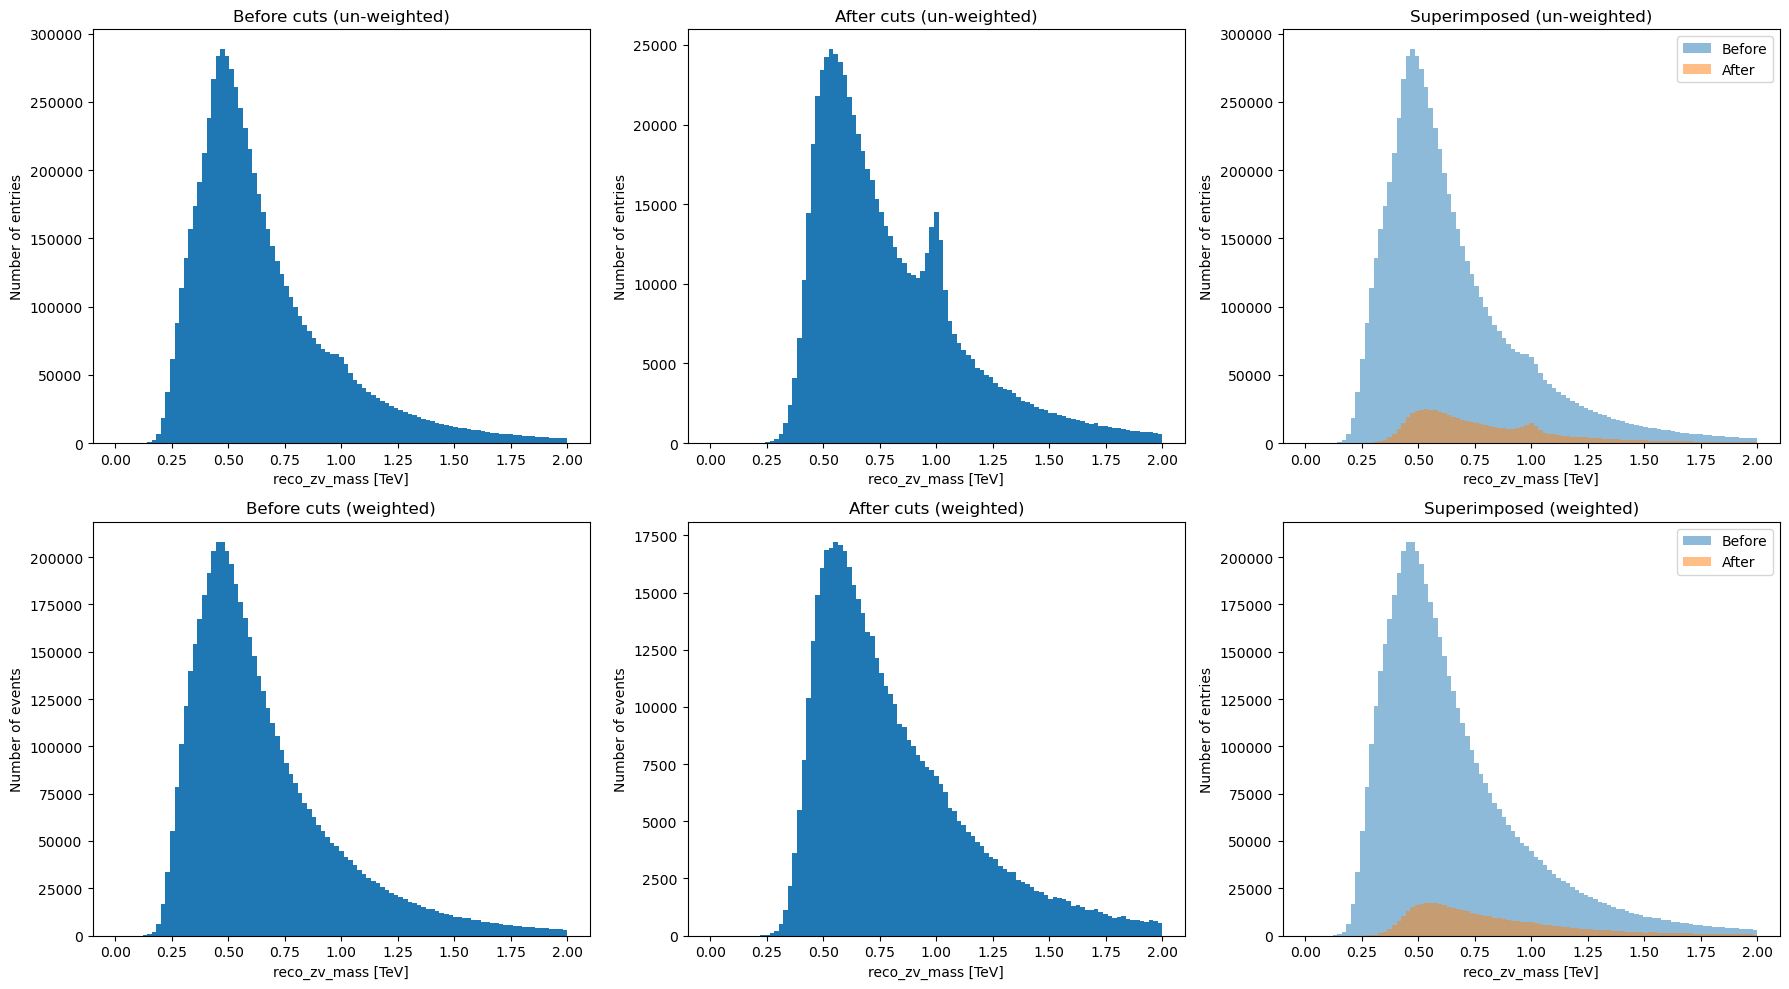

In [32]:
fig, ax = plt.subplots(2,3, figsize=(18,10))
ax = ax.flatten()

ax[0].hist(combined[var_names[-1]]/1e6,alpha=1,bins=np.linspace(0,2,100))
ax[0].set_xlabel(var_names[-1]+" [TeV]")
ax[0].set_ylabel("Number of entries")
ax[0].set_title("Before cuts (un-weighted)")

ax[1].hist(combined_cut[var_names[-1]]/1e6,alpha=1,bins=np.linspace(0,2,100))
ax[1].set_xlabel(var_names[-1]+" [TeV]")
ax[1].set_ylabel("Number of entries")
ax[1].set_title("After cuts (un-weighted)")

ax[2].hist(combined[var_names[-1]]/1e6,alpha=0.5,bins=np.linspace(0,2,100))
ax[2].hist(combined_cut[var_names[-1]]/1e6,alpha=0.5,bins=np.linspace(0,2,100))
ax[2].set_xlabel(var_names[-1]+" [TeV]")
ax[2].set_ylabel("Number of entries")
ax[2].set_title("Superimposed (un-weighted)")
ax[2].legend(["Before","After"])

ax[3].hist(combined[var_names[-1]]/1e6,weights=combined.FullEventWeight,alpha=1,bins=np.linspace(0,2,100))
ax[3].set_xlabel(var_names[-1]+" [TeV]")
ax[3].set_ylabel("Number of events")
ax[3].set_title("Before cuts (weighted)")

ax[4].hist(combined_cut[var_names[-1]]/1e6,weights=combined_cut.FullEventWeight,alpha=1,bins=np.linspace(0,2,100))
ax[4].set_xlabel(var_names[-1]+" [TeV]")
ax[4].set_ylabel("Number of events")
ax[4].set_title("After cuts (weighted)")

ax[5].hist(combined[var_names[-1]]/1e6,alpha=0.5,bins=np.linspace(0,2,100),weights=combined.FullEventWeight)
ax[5].hist(combined_cut[var_names[-1]]/1e6,alpha=0.5,bins=np.linspace(0,2,100),weights=combined_cut.FullEventWeight)
ax[5].set_xlabel(var_names[-1]+" [TeV]")
ax[5].set_ylabel("Number of entries")
ax[5].set_title("Superimposed (weighted)")
ax[5].legend(["Before","After"])

fig.tight_layout()

Following the cuts the background distribution is significantly reduced while the signal peak has become more prominent. These plots show that the background has been reduced close to uniformly across the reco_zv_mass range and hence little sculpting has been introduced after the cuts.

In [33]:
print("Total background events before cut (inclusive region):",background.FullEventWeight.sum())
print("Total signal events before cut (inclusive region):",signal.FullEventWeight.sum())

Total background events before cut (inclusive region): 5402673.571321472
Total signal events before cut (inclusive region): 4200.16125602195


In [34]:
print("Total background events after cut (inclusive region):",background_cut.FullEventWeight.sum())
print("Total signal events after cut (inclusive region):",signal_cut.FullEventWeight.sum())

Total background events after cut (inclusive region): 497175.3876183132
Total signal events after cut (inclusive region): 2806.2908028451448


In the inclusive region background events are reduced by over 90%, while the majority of the signal is retained.

<!-- The reduction in background events in the inclusive region is greater than the signal region following the cuts. This is because background events outside of the signal region have variable values which are further from the signal distribution and are removed more easily with the cuts. -->

The signal region which we will consider is between 0.8 and 1.4 TeV in the reco_zv_mass spectrum.

Below we determine the signal and background counts for this region, before and after the cuts.

In [35]:
sig_reg_bkg = (background.reco_zv_mass<1.4e6)*(background.reco_zv_mass>0.8e6)
sig_reg_sig = (signal.reco_zv_mass<1.4e6)*(signal.reco_zv_mass>0.8e6)
sig_reg_bkg_cut = (background_cut.reco_zv_mass<1.4e6)*(background_cut.reco_zv_mass>0.8e6)
sig_reg_sig_cut = (signal_cut.reco_zv_mass<1.4e6)*(signal_cut.reco_zv_mass>0.8e6)

In [36]:
print("Total background events before cut (signal region):",background.FullEventWeight[sig_reg_bkg].sum())
print("Total signal events before cut (signal region):",signal.FullEventWeight[sig_reg_sig].sum())

Total background events before cut (signal region): 1100299.6220057502
Total signal events before cut (signal region): 3993.380790239483


In [37]:
print("Total background events after cut (signal region):",background_cut.FullEventWeight[sig_reg_bkg_cut].sum())
print("Total signal events after cut (signal region):",signal_cut.FullEventWeight[sig_reg_sig_cut].sum())

Total background events after cut (signal region): 161838.19230887055
Total signal events after cut (signal region): 2730.689759563001


In [38]:
print("Fraction of background passing cuts (signal region):",\
      background_cut.FullEventWeight[sig_reg_bkg_cut].sum()/background.FullEventWeight[sig_reg_bkg].sum())
print("Fraction of signal passing cuts (signal region):",\
      signal_cut.FullEventWeight[sig_reg_sig_cut].sum()/signal.FullEventWeight[sig_reg_sig].sum())

Fraction of background passing cuts (signal region): 0.1470855656696979
Fraction of signal passing cuts (signal region): 0.6838040004192142


The total number of background events in the signal region was reduced by approximately 85% while the number of signal events was only reduced by 32%. This shows that the cuts were successful in reducing the background while retaining the signal.

## 2. Fitting and hypothesis-testing (30%)

Making plots for the weighted signal, background and combined disitrbutions inside the 0.8 to 1.4 TeV signal region and saving their bins and bin counts.

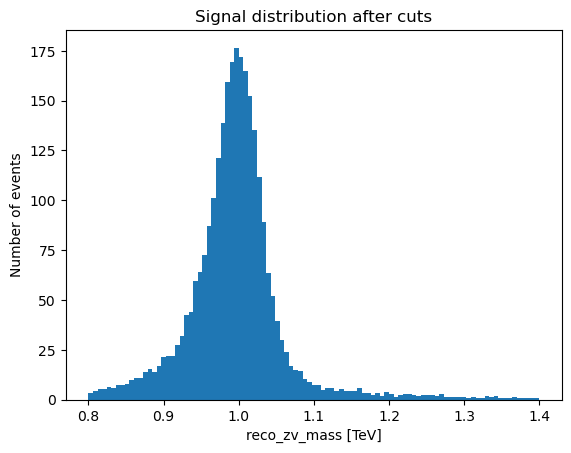

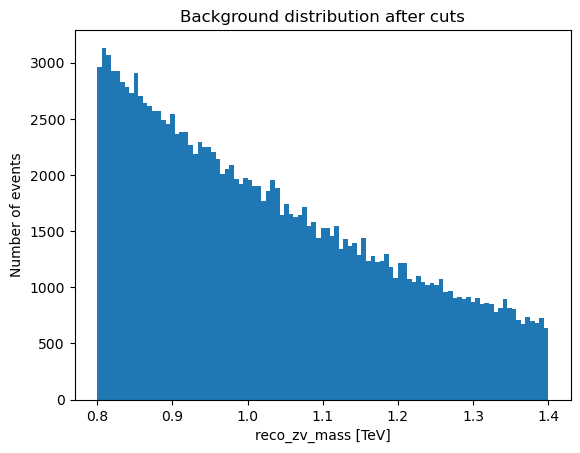

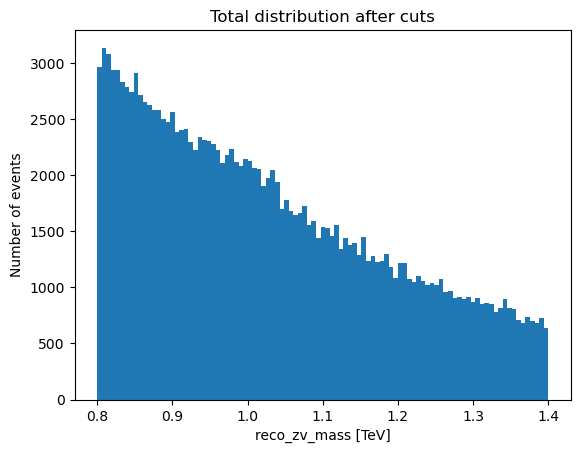

In [39]:
signal_obs = plt.hist(signal_cut[var_names[-1]]/1e6,bins=np.linspace(0.8e6,1.4e6,100)/1e6,weights=signal_cut.FullEventWeight)
plt.title("Signal distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

back_obs = plt.hist(background_cut[var_names[-1]]/1e6,bins=np.linspace(0.8e6,1.4e6,100)/1e6,weights=background_cut.FullEventWeight)
plt.title("Background distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

total_obs = plt.hist(combined_cut["reco_zv_mass"]/1e6,bins=np.linspace(0.8e6,1.4e6,100)/1e6,weights=combined_cut.FullEventWeight)
plt.title("Total distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

After weighting the entries, the signal gets significantly shrunk while the background remains a similar shape. This is because the signal weights are smaller than the background weights.

From the combined distribution it becomes harder to tell the signal once it gets weighted.

In [40]:
sensitivity_manual = signal_obs[0].sum()/np.sqrt(back_obs[0].sum())
print("The sensitivty achieved through the manual cuts is:",sensitivity_manual)

The sensitivty achieved through the manual cuts is: 6.787843993151443


We can use this sensitivity as a benchmark to compare with the sensitivity achieved by using the neural network later on.

### Signal only fit

Determining the bin widths for normalisation and the bin centres as the input x values to the fit function.

In [41]:
bin_width = signal_obs[1][1]-signal_obs[1][0]

bin_centres = np.linspace(signal_obs[1][0]+(bin_width/2),signal_obs[1][-1]-(bin_width/2),99)

Determining the number of events for use in normalisation

In [42]:
n_events = signal_obs[0].sum()

In [43]:
bins = signal_obs[1] # Setting the bins for later

Calculating the number of observed signal events and their standard deviation using their weights

In [44]:
n_observed = []
sigma_sq = []
for i in range(99):
    # Determine the weights for each bin separately
    mask = ((signal_cut["reco_zv_mass"]/1e6)>bins[i])*((signal_cut["reco_zv_mass"]/1e6)<bins[i+1])
    weights = signal_cut.FullEventWeight[mask]
    
    n_observed.append(np.sum(weights.values))
    sigma_sq.append(np.sum(weights.values**2))

#### Trying a gaussian fit

Creating the Gaussian PDF function and normalising it.

In [45]:
def gauss_PDF(x,mean,sigma):
    gauss_dist = lambda x: scipy.stats.norm.pdf(x,mean,sigma)
    area, _ = integrate.quad(gauss_dist,0.8,1.4) # Calculate the normalisation constant
    return (1/area)*scipy.stats.norm.pdf(x,mean,sigma)

Creating the chi-squared function for the gaussian fit

In [46]:
 def chisq_gauss(mean,sigma):
    n_expected_sig = n_events*bin_width*gauss_PDF(bin_centres,mean,sigma)
    chi_sq_sum = 0
    for i in range(0,99):
        if n_expected_sig[i] < 0:
            n_expected_sig[i] = 1e-3
        chi_sq_sum += ((n_observed[i]-n_expected_sig[i])**2)/(sigma_sq[i])
    return chi_sq_sum

In [47]:
# Set the minimisation parameters
m = Minuit(chisq_gauss, mean=1, sigma=0.1)
m.limits["sigma"] = (0,0.5) 

# Set the errors on the initial start values
m.errors=[0.1,0.1]

# Set the increase in Chi squared for the 1-SD error calculation
m.errordef=1.0

# Run the minimisation
m = m.migrad()

In [48]:
# Printing the final results and their error
fstr = "{0:2.4f}"
mean_manual = m.values["mean"]
mean_manual_err = m.errors["mean"]
sigma_manual = m.values["sigma"]
sigma_manual_err = m.errors["sigma"]
print("{:2s}".format("mean"), "=  ", fstr.format(mean_manual), " +/- ", fstr.format(mean_manual_err))
print("{:2s}".format("sigma"), "=  ", fstr.format(sigma_manual), " +/- ", fstr.format(sigma_manual_err))

mean =   0.9933  +/-  0.0003
sigma =   0.0395  +/-  0.0003


The minimiser has achieved a good fit with low uncertainty in the parameters.

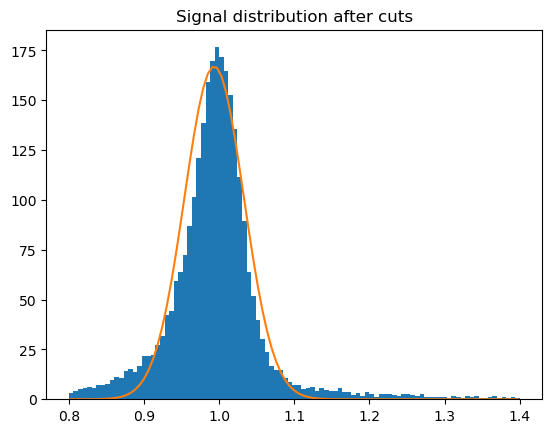

In [49]:
# Overlaying the fitted curve over the original distribution
plt.hist(signal_cut[var_names[-1]]/1e6,bins=np.linspace(0.8e6,1.4e6,100)/1e6,weights=signal_cut.FullEventWeight)
plt.plot(bin_centres, n_events*bin_width*gauss_PDF(bin_centres,mean_manual,sigma_manual))
plt.title("Signal distribution after cuts")
plt.show()

Gaussian is wider than signal peak as the signal has extended tails.

In [50]:
print("The chi-squared value from the Gaussian fit is:",round(chisq_gauss(mean_manual,sigma_manual),4))

The chi-squared value from the Gaussian fit is: 2891.1246


#### Trying a crystal ball fit

In [51]:
from scipy.stats import crystalball

Creating the crystal ball PDF function and normalising it.

In [52]:
def CB_PDF(x,beta,power,mean,sigma):
    CB_dist = lambda x: scipy.stats.crystalball.pdf(x,beta,power,mean,sigma)
    area, _ = integrate.quad(CB_dist,0.8,1.4) # Calculate the normalisation constant
    return (1/area)*scipy.stats.crystalball.pdf(x,beta,power,mean,sigma)

In [53]:
#create a function for the chi squared crystal ball fit 
def chisq_CB(beta,power,mean,sigma):
    n_expected_sig = n_events*bin_width*CB_PDF(bin_centres,beta,power,mean,sigma)
    chi_sq_sum = 0
    for i in range(0,99):
        if n_expected_sig[i] < 0:
            n_expected_sig[i] = 1e-3
        chi_sq_sum += ((n_observed[i]-n_expected_sig[i])**2)/(sigma_sq[i])
    return chi_sq_sum

In [54]:
# Set the minimisation parameters
m = Minuit(chisq_CB, beta=2, power=2, mean=1, sigma=0.05)
m.limits["sigma"] = (0.01,0.5) 
m.limits["beta"] = (0,5) 
m.limits["power"] = (1,10) 

# Set the errors on the initial start values
m.errors=[0.1,0.1,0.1,0.1]

# Set the increase in Chi squared for the 1-SD error calculation
m.errordef=1.0

# Run the minimisation
m = m.migrad()

In [55]:
# Printing the final results and their error
fstr = "{0:2.4f}"

CB_mean = m.values["mean"]
CB_mean_err = m.errors["mean"]
CB_sigma = m.values["sigma"]
CB_sigma_err = m.errors["sigma"]
CB_beta = m.values["beta"]
CB_beta_err = m.errors["beta"]
CB_power = m.values["power"]
CB_power_err = m.errors["power"]

print("{:2s}".format("mean"), "=  ", fstr.format(CB_mean), " +/- ", fstr.format(CB_mean_err))
print("{:2s}".format("sigma"), "=  ", fstr.format(CB_sigma), " +/- ", fstr.format(CB_sigma_err))
print("{:2s}".format("beta"), "=  ", fstr.format(CB_beta), " +/- ", fstr.format(CB_beta_err))
print("{:2s}".format("power"), "=  ", fstr.format(CB_power), " +/- ", fstr.format(CB_power_err))

mean =   0.9976  +/-  0.0003
sigma =   0.0340  +/-  0.0003
beta =   1.0851  +/-  0.0336
power =   3.6095  +/-  0.3851


The minimiser achieves a good fit with low parameter uncertainties.

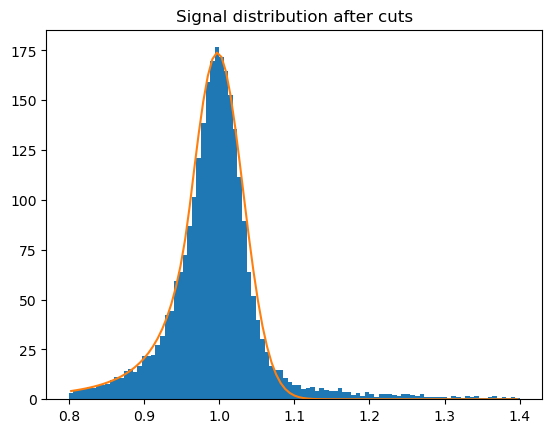

In [56]:
# Overlaying the fitted curve over the original distribution
plt.hist(signal_cut[var_names[-1]]/1e6,bins=np.linspace(0.8,1.4,100),weights=signal_cut.FullEventWeight)
plt.plot(bin_centres, n_events*bin_width*CB_PDF(bin_centres,CB_beta,CB_power,CB_mean,CB_sigma))
plt.title("Signal distribution after cuts")
plt.show()

In [57]:
print("The chi-squared value from the crystal-ball fit is:",round(chisq_CB(CB_beta,CB_power,CB_mean,CB_sigma),4))

The chi-squared value from the crystal-ball fit is: 1338.0869


The crystal-ball fit is able to achieve a lower chi-squared value and hence is a better fit. However, the combined signal+background fit did not minimise well with the crystal-ball function and so the simpler Gaussian function was used instead.

### Background only fit

Calculating the number of observed background events and their standard deviation using their weights

In [58]:
n_observed = []
sigma_sq = []
for i in range(99):
    # Determine the weights for each bin separately
    mask = ((background_cut["reco_zv_mass"]/1e6)>bins[i])*((background_cut["reco_zv_mass"]/1e6)<bins[i+1])
    weights = background_cut.FullEventWeight[mask]
    
    n_observed.append(np.sum(weights.values))
    sigma_sq.append(np.sum(weights.values**2))

In [59]:
n_events = back_obs[0].sum()

#### Trying a polynomial fit

Using a second order polynomial as the fit function and normalising it.

In [60]:
def poly_PDF(x,a,b,c):
    poly_dist = lambda x: a+(b*x)+(c*x**2)
    area, _ = integrate.quad(poly_dist,0.8,1.4) # Calculate the normalisation constant
    return (1/area)*(a+(b*(x))+(c*(x)**2))

Creating a function for the chi-squared polynomial fit 

In [61]:
def chisq_poly(a,b,c):
    n_expected_back = n_events*bin_width*poly_PDF(bin_centres,a,b,c)
    chi_sq_sum = 0
    for i in range(0,99):
        if n_expected_back[i] < 0:
            n_expected_back[i] = 1e-3
        chi_sq_sum += ((n_observed[i]-n_expected_back[i])**2)/(sigma_sq[i])
    return chi_sq_sum

In [62]:
# Set the minimisation parameters
m = Minuit(chisq_poly, a=10,b=1,c=0.1)

# Set the errors on the initial start values
m.errors=[0.1,0.1,0.1]

# Set the increase in Chi squared for the 1-SD error calculation
m.errordef=1.0

# Run the minimisation
m = m.migrad()

In [63]:
# Printing the final results and their error
fstr = "{0:2.4f}"
poly_a = m.values["a"]
poly_a_err = m.errors["a"]
poly_b = m.values["b"]
poly_b_err = m.errors["b"]
poly_c = m.values["c"]
poly_c_err = m.errors["c"]

print("{:2s}".format("a"), "=  ", fstr.format(poly_a), " +/- ", fstr.format(poly_a_err))
print("{:2s}".format("b"), "=  ", fstr.format(poly_b), " +/- ", fstr.format(poly_b_err))
print("{:2s}".format("c"), "=  ", fstr.format(poly_c), " +/- ", fstr.format(poly_c_err))

a  =   6.0609  +/-  0.2522
b  =   -7.1934  +/-  0.2900
c  =   2.2459  +/-  0.0979


The fit values have low uncertainties, showing that a good fit was achieved.

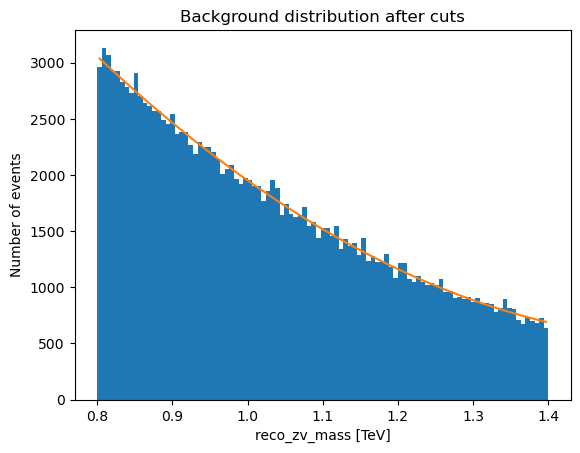

In [64]:
# Overlaying the fitted curve over the original distribution
plt.hist(background_cut[var_names[-1]]/1e6,bins=np.linspace(0.8,1.4,100),weights=background_cut.FullEventWeight)
plt.plot(bin_centres, n_events*bin_width*poly_PDF(bin_centres,poly_a,poly_b,poly_c))
plt.title("Background distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

In [65]:
print("The chi-squared value from the polynomial fit is:",round(chisq_poly(poly_a,poly_b,poly_c),4))

The chi-squared value from the polynomial fit is: 103.2637


#### Trying an exponential fit

Creating the exponential PDF and normalising it.

In [66]:
# Generate the normalised exponential PDF
def exp_PDF(x,tau):
    exp_dist = lambda x: np.exp(-x/tau)
    area, _ = integrate.quad(exp_dist,0.8,1.4) # Calculate the normalisation constant
    return (1/area)*np.exp(-x/tau)

In [67]:
#create a function for the chi squared exponential fit
def chisq_exp(tau):
    n_expected_back = n_events*bin_width*exp_PDF(bin_centres,tau)
    chi_sq_sum = 0
    for i in range(0,99):
        if n_expected_back[i] < 0:
            n_expected_back[i] = 1e-3
        chi_sq_sum += ((n_observed[i]-n_expected_back[i])**2)/(sigma_sq[i])
    return chi_sq_sum

In [68]:
# Set the minimisation parameters
m = Minuit(chisq_exp, tau=1)

# Set the errors on the initial start values
m.errors=[0.1]

# Set the increase in Chi squared for the 1-SD error calculation
m.errordef=1.0

# Run the minimisation
m = m.migrad()

In [69]:
# Printing the final results and their error
fstr = "{0:2.4f}"
exp_tau = m.values["tau"]
exp_tau_err = m.errors["tau"]

print("{:2s}".format("tau"), "=  ", fstr.format(exp_tau), " +/- ", fstr.format(exp_tau_err))

tau =   0.3992  +/-  0.0033


A good fit was achieved with low uncertainties.

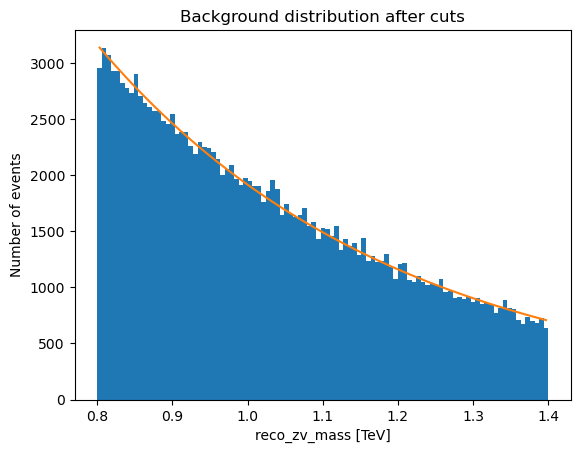

In [70]:
# Overlaying the fitted curve over the original distribution
plt.hist(background_cut[var_names[-1]]/1e6,bins=np.linspace(0.8,1.4,100),weights=background_cut.FullEventWeight)
plt.plot(bin_centres, n_events*bin_width*exp_PDF(bin_centres,exp_tau))
plt.title("Background distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

In [71]:
print("The chi-squared value from the exponential fit is:",round(chisq_exp(exp_tau),4))

The chi-squared value from the exponential fit is: 115.6794


Exponential function is a worse fit as it has a higher chi-squared value.

Therefore the background is best modelled by a polynomial curve.

### Fitting signal+background distribution

Updating the number of events to the total distribution.

In [72]:
n_events = total_obs[0].sum()

Fixing the signal Gaussian mean and sigma from the fits based on the manual cuts.

In [73]:
mean = mean_manual

In [74]:
sigma = sigma_manual

Calculating the total number of observed events and their standard deviation using their weights.

In [75]:
n_observed = []
sigma_sq = []
for i in range(99):
    # Determine the weights for each bin separately
    mask = ((combined_cut["reco_zv_mass"]/1e6)>bins[i])*((combined_cut["reco_zv_mass"]/1e6)<bins[i+1])
    weights = combined_cut.FullEventWeight[mask]
    
    n_observed.append(np.sum(weights.values))
    sigma_sq.append(np.sum(weights.values**2))

Creating the combined chi-squared fit.

In [76]:
def chisq_combined(a,b,c,F):
    # Separately normalised counts
    n_expected_back = n_events*bin_width*poly_PDF(bin_centres,a,b,c) 
    n_expected_sig = n_events*bin_width*gauss_PDF(bin_centres,mean,sigma)
    # Combine separately normalised counts
    n_expected = ((1-F) * n_expected_back) + (F * n_expected_sig) 

    chi_sq_sum = 0
    for i in range(0,99):
        if n_expected[i] < 0:
            n_expected[i] = 1e-3
        chi_sq_sum += ((n_observed[i]-n_expected[i])**2)/(sigma_sq[i])
    return chi_sq_sum

#### H0 hypothesis test

Fitting assuming no signal.

In [77]:
# Set the minimisation parameters
m = Minuit(chisq_poly, a=10,b=1,c=0.1)

# Set the errors on the initial start values
m.errors=[0.1,0.1,0.1]

# Set the increase in Chi squared for the 1-SD error calculation
m.errordef=1.0

# Run the minimisation
m = m.migrad()

In [78]:
# Printing the final results and their error
fstr = "{0:2.4f}"
poly_a = m.values["a"]
poly_a_err = m.errors["a"]
poly_b = m.values["b"]
poly_b_err = m.errors["b"]
poly_c = m.values["c"]
poly_c_err = m.errors["c"]

print("{:2s}".format("a"), "=  ", fstr.format(poly_a), " +/- ", fstr.format(poly_a_err))
print("{:2s}".format("b"), "=  ", fstr.format(poly_b), " +/- ", fstr.format(poly_b_err))
print("{:2s}".format("c"), "=  ", fstr.format(poly_c), " +/- ", fstr.format(poly_c_err))

a  =   5.5164  +/-  0.2225
b  =   -6.4175  +/-  0.2495
c  =   1.9491  +/-  0.0840


The fit values have low uncertainties, showing that a good fit was achieved.

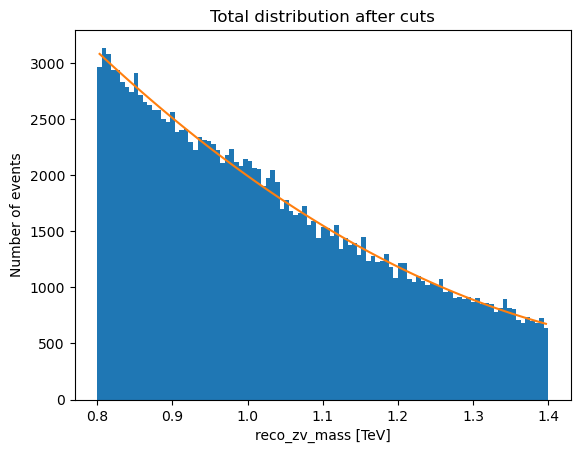

In [79]:
# Overlaying the fitted curve over the original distribution
plt.hist(combined_cut[var_names[-1]]/1e6,bins=np.linspace(0.8,1.4,100),weights=combined_cut.FullEventWeight)
plt.plot(bin_centres, n_events*bin_width*poly_PDF(bin_centres,poly_a,poly_b,poly_c))
plt.title("Total distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

In [80]:
# Calculating the chi_squared value for the final fit
H0_chi_squared = chisq_poly(poly_a,poly_b,poly_c)

In [81]:
print("The chi-squared value from the background only fit (H0) is:",round(H0_chi_squared,4))

The chi-squared value from the background only fit (H0) is: 135.8159


#### H1 hypothesis test

Fitting assuming a signal is present in the background.

In [82]:
# Set the minimisation parameters
m = Minuit(chisq_combined, a=10,b=1,c=0.1,F=0.01)
m.limits["F"] = (0,1) 

# Set the errors on the initial start values
m.errors=[0.1,0.1,0.1,0.1]

# Set the increase in Chi squared for the 1-SD error calculation
m.errordef=1.0

# Run the minimisation
m = m.migrad()

In [83]:
# Printing the final results and their error
fstr = "{0:2.4f}"
comb_a = m.values["a"]
comb_a_err = m.errors["a"]
comb_b = m.values["b"]
comb_b_err = m.errors["b"]
comb_c = m.values["c"]
comb_c_err = m.errors["c"]
comb_F = m.values["F"]
comb_F_err = m.errors["F"]
# val5 = m.values["e"]
# err5 = m.errors["e"]

print("{:2s}".format("a"), "=  ", fstr.format(comb_a), " +/- ", fstr.format(comb_a_err))
print("{:2s}".format("b"), "=  ", fstr.format(comb_b), " +/- ", fstr.format(comb_b_err))
print("{:2s}".format("c"), "=  ", fstr.format(comb_c), " +/- ", fstr.format(comb_c_err))
# print("{:2s}".format("d"), "=  ", fstr.format(val4), " +/- ", fstr.format(err4))
print("{:2s}".format("F"), "=  ", fstr.format(comb_F), " +/- ", fstr.format(comb_F_err))

a  =   6.1634  +/-  0.2575
b  =   -7.2969  +/-  0.2949
c  =   2.2705  +/-  0.0998
F  =   0.0130  +/-  0.0023


A good fit was made with low uncertainties on the fit parameters.

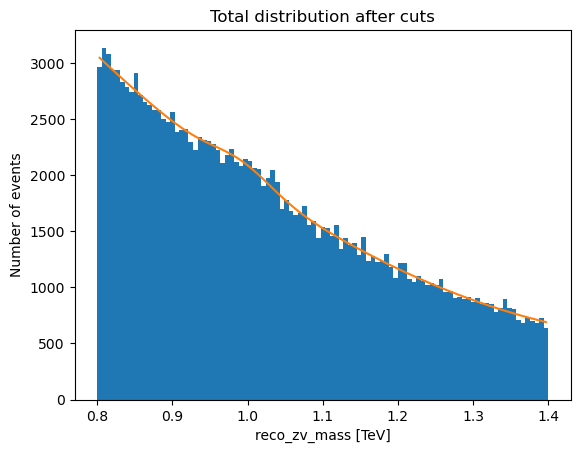

In [84]:
# Overlaying the fitted curve over the original distribution
plt.hist(np.append(signal_cut[var_names[-1]],background_cut[var_names[-1]])/1e6,bins=np.linspace(0.8,1.4,100),weights=combined_cut.FullEventWeight)
plt.plot(bin_centres, n_events*bin_width*((1-comb_F)*poly_PDF(bin_centres,comb_a,comb_b,comb_c)+comb_F*gauss_PDF(bin_centres,mean,sigma)))
plt.title("Total distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

We can see a small signal bump in the fit around 1 TeV.

In [85]:
# Calculating the chi_squared value for the final fit
H1_chi_squared = chisq_combined(comb_a,comb_b,comb_c,comb_F)

In [86]:
print("The chi-squared value from the signal+background fit (H1) is:",round(H1_chi_squared,4))

The chi-squared value from the signal+background fit (H1) is: 103.1884


In [87]:
chi_sq_diff = H0_chi_squared-H1_chi_squared

We determine a p-value using a delta-chi2 fit with 1 extra parameter between the H0 and H1 hypotheses. In the H1 hypothesis we additionally vary the fraction between signal and background events.

In [88]:
pvalue = 1 - scipy.stats.chi2.cdf(chi_sq_diff,1) 
print("The p-value is: ",pvalue)

The p-value is:  1.1161978452634003e-08


A very low p-value was achieved, meaning the probability of the signal being a fluctuation is very low.

### Finding the Z-score

In [89]:
n_sigmas = erfinv(1 - pvalue )* np.sqrt(2)
print("The Z-score is: ",n_sigmas)

The Z-score is:  5.712055326327273


Z-score is above 5 sigma meaning that we have significant evidence for the presence of a signal. Given the low fit uncertainties we can be quite confident in this result.

## 3. Employing a NN classifier (40%)

Training is done using the entries which were selected from the manual cuts. It was found that training on the already selected entries provided the highest sensitivity in the final result. The network can improve on the manual cuts which already significantly reduce the background while retaining a large fraction of the signal.

In [90]:
n_signal = signal_cut.shape[0]

In [91]:
# 50:50 training data split
training_data = pd.concat([signal_cut,background_cut[:n_signal]],ignore_index=True)
Answer_to_all_questions = 42
training_data = shuffle(training_data, random_state=Answer_to_all_questions)
training_data.reset_index(drop=True, inplace=True)

In [92]:
training_data.head(5)

,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,fatjet_phi,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,0.899060,35664.527,1,88237.19,219311.48,0.018866,1.443849,226877.55,0.118862,0.895407,...,-1.484501,-2.221847,149540.10,358869.22,1,-2.318887,-2.305073,69936.380,680088.44,-1.00
1,0.075184,63279.188,1,86151.93,449290.60,0.072311,0.679144,541808.70,0.726939,-2.294584,...,-0.053444,0.640403,259488.77,205620.72,-1,-0.366048,0.864500,192574.380,975066.20,1000000.10
2,0.131711,35445.990,0,90348.65,469778.80,0.113902,1.051427,544493.56,0.398959,0.730698,...,0.163244,-2.307000,280504.38,194192.64,-1,-0.202222,-2.440777,190288.530,1000543.60,1000000.50
3,0.817027,9776.132,1,82603.23,256332.06,0.189292,1.472981,420134.70,-1.170417,0.326426,...,-1.204545,-2.706879,143703.52,143003.19,-1,-0.666206,-3.042527,116239.555,513705.78,-1.00
4,0.080569,12498.512,1,92508.52,495161.28,0.091260,0.875906,726410.70,-1.002712,1.336459,...,-0.764102,-1.955585,411654.44,94098.65,-1,-0.396075,-1.635626,87171.270,987425.20,1000001.44


Training data looks good.

In [93]:
select_training = training_data[np.append(var_names[:-1],"isSignal")]

In [94]:
select_training = select_training.drop(["Zll_pt","lep1_pt","fatjet_pt","lep2_pt"], axis=1)

It was found that training without the most correlated variables with the <b>reco_zv_mass</b> (<b>fatjet_pt</b>, <b>Zll_pt</b>, <b>lep1_pt</b> and <b>lep2_pt</b>) produced the best results. By removing these variables the network cannot using their correlation to learn the <b>reco_zv_mass</b> of the events and hence reduces background sculpting and improves the significance of the final result. The selected training variables were chosen to have below 20% correlation with <b>reco_zv_mass</b>.

This works by forcing the network to learn differences in signal and background distributions other than in the <b>reco_zv_mass</b>. Therefore the network does not preferentially rejected background outside the signal region but instead reduces background more uniformly across the full <b>reco_zv_mass</b> range. This allows the background to be reduced the most in the signal region, making the signal peak the most prominent. Furthermore, by reducing the sculpting, the background distribution shape was retained which allows for a better fit using a polynomial curve. This allows to achieve much lower uncertainties in the fit and allows to test our H1 and H0 hypotheses more confidently. 

In [95]:
features = select_training[select_training.columns[:-1]]
target = select_training.isSignal

Standarising the training features and splitting the entries into a training and testing set.

In [96]:
sc = preprocessing.StandardScaler()
features = sc.fit_transform(features)
# set random seed
Answer_to_all_questions = 42
# train - test split of dataset
x_train, x_test, y_train, y_test = model_selection.train_test_split(features, target, \
                                                                    test_size=0.2,
                                                                    random_state = Answer_to_all_questions)
print (x_train.shape, x_test.shape, y_train.shape,y_test.shape)

(53214, 4) (13304, 4) (53214,) (13304,)


Creating the function to define the NN model

In [97]:
def my_model(num_inputs,num_nodes,extra_depth,drop_out):
    # create model
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=num_inputs, kernel_initializer="normal", activation="relu"))
    model.add(Dropout(drop_out))
    for i in range (extra_depth):
    # code up the extra layers here
        model.add(Dense(num_nodes, kernel_initializer="normal", activation="relu"))
        model.add(Dropout(drop_out))
    model.add(Dense(1, activation="sigmoid"))
    # Compile model
    model.compile(loss="binary_crossentropy",optimizer="adam", metrics =["accuracy"])
    return model

Setting the NN model hyperparameters

In [98]:
num_nodes = 30
extra_depth = 1
drop_out = 0.1
num_inputs = x_train.shape[1]
model = my_model(num_inputs,num_nodes,extra_depth,drop_out)

2023-04-14 01:49:21.796603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The number of nodes and number of layers were chosen so maximise classification performance. The hidden layers and number of nodes was kept smaller to avoid overfitting the relatively small training set. Too many nodes or layers meant that high regularisation needed to be used which was not an optimal solution as it compromised training performance. 

<!-- A large network was also able to use correlations to learn the <b>reco_zv_mass</b> variable and could more easily cause sculpting of the background which negatively impacted the sensitivity. -->

The level of drop_out was tuned by looking at the training and validation accuracy curves. If the  training curve platued really early on the drop_out was too large, whereas if the validation curve had a turning point and began to fall then the drop_out was too low.

In [99]:
batchSize = 512
N_epochs = 50

The batch size of 512 was found to allow reproducible results in training and achieved high performance.

50 epochs were used as the network did not show significant improvements in performance for more epochs.

Training was tried using the sample weights. However, using the sample weights significantly increased the distortion of the background distribution and made it more sculpted. The sensitivity in the final result also decreased when the sample weights were used in training. Training was therefore performed without using the sample weights.

In [100]:
history = model.fit(x_train,y_train,batch_size=batchSize,epochs=N_epochs,verbose=1,
                    validation_data=(x_test,y_test))

Epoch 1/50
104/104 [==============================] - 1s 4ms/step - loss: 0.6558 - accuracy: 0.6305 - val_loss: 0.6154 - val_accuracy: 0.6624
Epoch 2/50
104/104 [==============================] - 0s 3ms/step - loss: 0.6105 - accuracy: 0.6630 - val_loss: 0.6032 - val_accuracy: 0.6675
Epoch 3/50
104/104 [==============================] - 0s 3ms/step - loss: 0.6051 - accuracy: 0.6674 - val_loss: 0.5993 - val_accuracy: 0.6729
Epoch 4/50
104/104 [==============================] - 0s 3ms/step - loss: 0.6032 - accuracy: 0.6694 - val_loss: 0.5974 - val_accuracy: 0.6739
Epoch 5/50
104/104 [==============================] - 0s 3ms/step - loss: 0.6011 - accuracy: 0.6692 - val_loss: 0.5965 - val_accuracy: 0.6745
Epoch 6/50
104/104 [==============================] - 0s 3ms/step - loss: 0.5997 - accuracy: 0.6720 - val_loss: 0.5960 - val_accuracy: 0.6742
Epoch 7/50
104/104 [==============================] - 0s 3ms/step - loss: 0.5995 - accuracy: 0.6714 - val_loss: 0.5953 - val_accuracy: 0.6721
Epoch 

Plotting the loss and accuracy curves from the NN training.

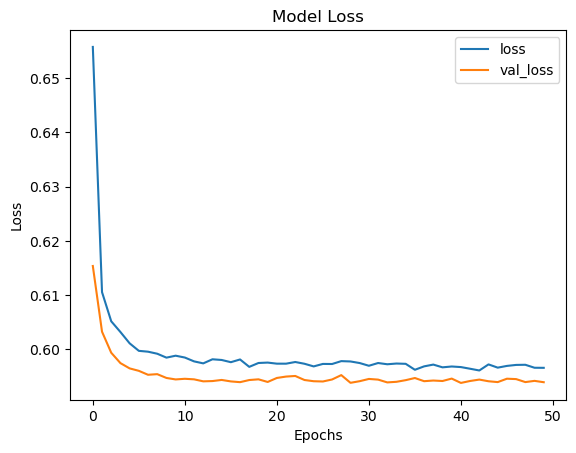

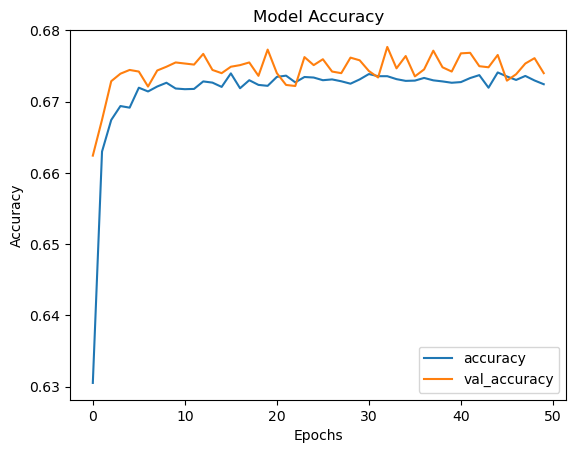

In [101]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["loss","val_loss"])
plt.show()

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["accuracy","val_accuracy"])
plt.show()

Both the loss and val_loss curves follow the same shape and the val_loss consistently descreases, so therefore there is no overfitting. The loss curves begin to plateau after around 20 epochs meaning that the model achieves good performance early on.

A similar relationship is seen for the accuracy curves. 

Both the loss and accuracy validation curves are better than the training curves due to the use of drop_out regularisation in training.

The trained NN is then tested using all of the events that were obtained from the manual cuts.

In [102]:
combined_test_cut = combined_cut[np.append(var_names[:-1],"isSignal")]

The number of variables removed in training was chosen to provide a good trade-off between neural network classification performance and the level of background sculpting in the signal region. The variables with reco_zv_mass correlation greater than 20% were not used in training.

In [103]:
combined_test_cut = combined_test_cut.drop(["Zll_pt","lep1_pt","fatjet_pt","lep2_pt"], axis=1)

In [104]:
features_test_cut = combined_test_cut[combined_test_cut.columns[:-1]]
combined_target_cut = combined_test_cut.isSignal

Standardising the testing features.

In [105]:
sc = preprocessing.StandardScaler()
features_test_cut = sc.fit_transform(features_test_cut)

In [106]:
print("Number of testing entries: ",features_test_cut.shape[0])

Number of testing entries:  666077


Determining the scores the network gives to each entry and then plotting the scores separately for signal and background.

In [107]:
score = model.predict(features_test_cut)

20815/20815 [==============================] - 13s 625us/step


In [108]:
def plot_score(score):
    bins = np.linspace(0,1,40)
    labels = ["Background","Signal"]
    for signal in [0,1]:
        mask = combined_target_cut == signal
        
        # Calculating weights to normalise each of the distributions
        non_zero = np.count_nonzero(~np.isnan(score[mask]))
        weights = np.ones_like(score[mask])/float(non_zero)
        
        plt.hist(score[mask],alpha=0.5, label=labels[signal],bins = bins,weights=weights)
    plt.xlabel("Discriminant score")
    plt.ylabel("Fraction")
    plt.legend()
    
    plt.show()

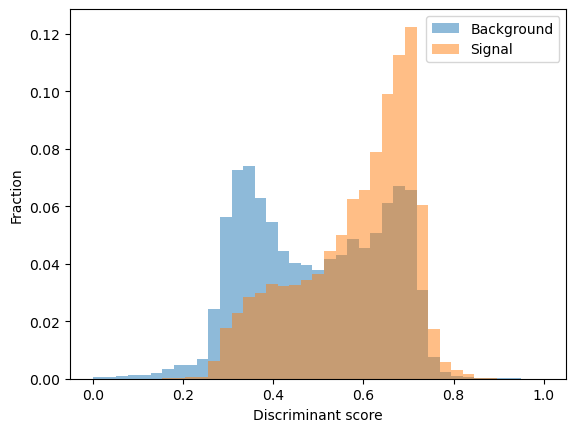

In [109]:
plot_score(score)

The neural network is able to achieve a good score separation between the signal and background events following the manual cuts. This means the network is able to create a further distinction between the signal and background to improve the sensitivity in the final selection.

In [110]:
prediction = score>0.5 # Events with score>0.5 are predicted as signal

Creating a confusion matrix for the predictions in the inclusive reco_zv_mass region.

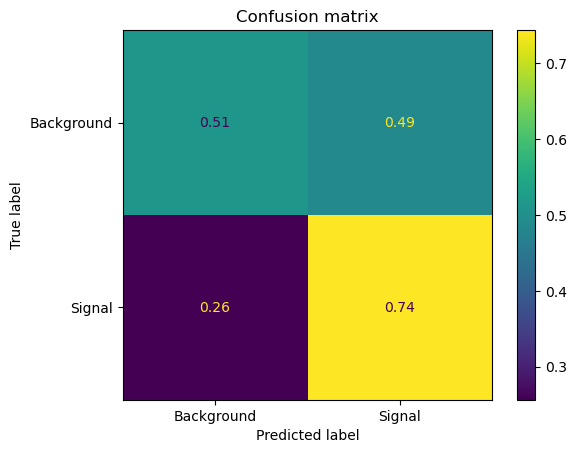

In [111]:
cm = confusion_matrix(combined_target_cut,prediction,normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Background","Signal"])

disp.plot()
plt.title("Confusion matrix")
plt.show()

Following the classification only events classified as signal are kept. We can see through the confusion matrix that in the inclusive region the total background has been more than halved and the signal has largely been retained. This is a desireable result as it means the signal peak becomes more prominent following the classification. 

Creating a separate dataframe with the entries which pass the NN classification. 

In [112]:
combined_cut_NN = combined_cut[prediction.flatten()]

Creating separate signal and background dataframes.

In [113]:
signal_cut_NN = combined_cut_NN[combined_cut_NN.isSignal==1]
background_cut_NN = combined_cut_NN[combined_cut_NN.isSignal==0]

Making plots for the weighted signal, background and combined distributions inside the 0.8 to 1.4 TeV signal region and saving their bins and bin counts.

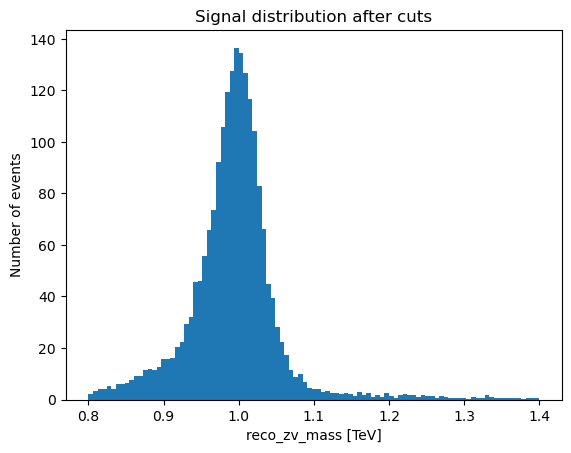

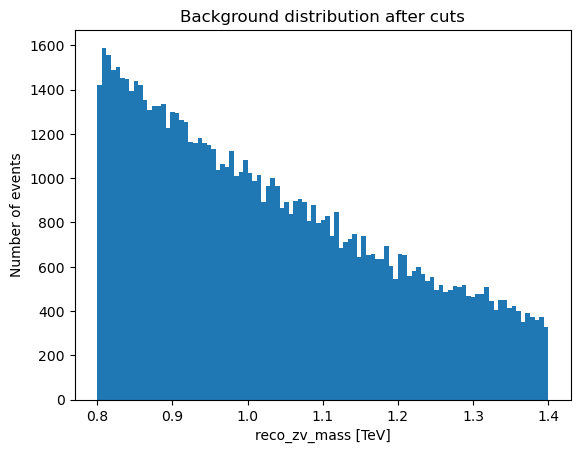

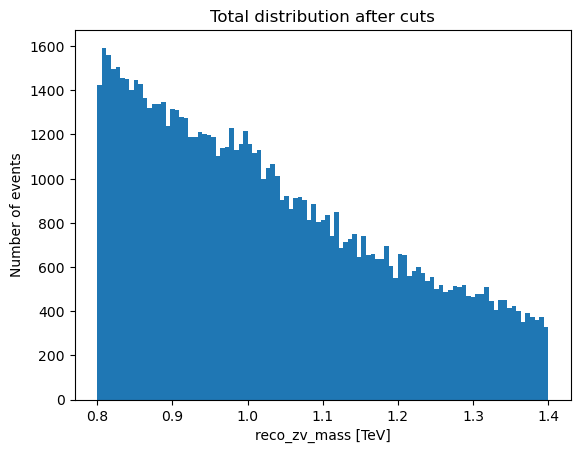

In [114]:
signal_obs_NN = plt.hist(signal_cut_NN[var_names[-1]]/1e6,bins=np.linspace(0.8,1.4,100),weights=signal_cut_NN.FullEventWeight)
plt.title("Signal distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

back_obs_NN = plt.hist(background_cut_NN[var_names[-1]]/1e6,bins=np.linspace(0.8,1.4,100),weights=background_cut_NN.FullEventWeight)
plt.title("Background distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

total_obs_NN = plt.hist(np.append(signal_cut_NN[var_names[-1]],background_cut_NN[var_names[-1]])/1e6,bins=np.linspace(0.8,1.4,100),weights=combined_cut_NN.FullEventWeight)
plt.title("Total distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

The background distribution has retained its shape and has been reduced uniformly, while the signal has become more prominent following the NN classification. No background sculpting can be seen.

The signal bump can now clearly be seen even after the events have been weighted.

In [115]:
print("Total background events after classification (signal region):",back_obs_NN[0].sum())
print("Total signal events after classification (signal region):",signal_obs_NN[0].sum())

Total background events after classification (signal region): 84358.65492190095
Total signal events after classification (signal region): 2032.1353525184438


In [116]:
print("Fraction of background passing classification (signal region):",\
      back_obs_NN[0].sum()/background_cut.FullEventWeight[sig_reg_bkg_cut].sum())
print("Fraction of signal passing classification (signal region):",\
      signal_obs_NN[0].sum()/signal_cut.FullEventWeight[sig_reg_sig_cut].sum())

Fraction of background passing classification (signal region): 0.5212530720863542
Fraction of signal passing classification (signal region): 0.7441838991052764


The total number of background events in the signal region was reduced by approximately 48% while the number of signal events was only reduced by 26%. This shows that the classification applied on top of the manual cuts has further decreased the background while retaining most of the signal.


<!-- the cuts were successful in reducing the background while retaining the signal. -->

In [117]:
sensitivity_NN = signal_obs_NN[0].sum()/np.sqrt(back_obs_NN[0].sum())
print("The sensitivty achieved by classification after the manual cuts is:",sensitivity_NN)

The sensitivty achieved by classification after the manual cuts is: 6.996612280560765


The sensitivity of the combined classifier and manual cut selection has increased over just the sensitivity achieved with the manual cuts alone. 

### Signal only fit

Updating the number of signal events selected.

In [118]:
n_events = signal_obs_NN[0].sum()

In [119]:
bins=np.linspace(0.8,1.4,100)

Calculating the number of classified signal events and their standard deviation using their weights

In [120]:
n_observed = []
sigma_sq = []
for i in range(99):
    # Determine the weights for each bin separately
    mask = ((signal_cut_NN["reco_zv_mass"]/1e6)>bins[i])*((signal_cut_NN["reco_zv_mass"]/1e6)<bins[i+1])
    weights = signal_cut_NN.FullEventWeight[mask]
    
    n_observed.append(np.sum(weights.values))
    sigma_sq.append(np.sum(weights.values**2))

In [121]:
# Set the minimisation parameters
m = Minuit(chisq_gauss, mean = 1, sigma=0.1) # Choosing reasonable starting values
m.limits["sigma"] = (0,0.6) # Making sure the gaussian does not get too wide

# Set the errors on the initial start values
m.errors=[0.1,0.1]

# Set the increase in Chi squared for the 1-SD error calculation
m.errordef=1.0

# Run the minimisation
m = m.migrad()

In [122]:
# Printing the final results and their error
fstr = "{0:2.4f}"
mean_NN = m.values["mean"]
mean_NN_err = m.errors["mean"]
sigma_NN = m.values["sigma"]
sigma_NN_err = m.errors["sigma"]
print("{:2s}".format("mean"), "=  ", fstr.format(mean_NN), " +/- ", fstr.format(mean_NN_err))
print("{:2s}".format("sigma"), "=  ", fstr.format(sigma_NN), " +/- ", fstr.format(sigma_NN_err))

mean =   0.9935  +/-  0.0003
sigma =   0.0379  +/-  0.0003


The minimiser has achieved a good fit with low uncertainties on the parameter fits.

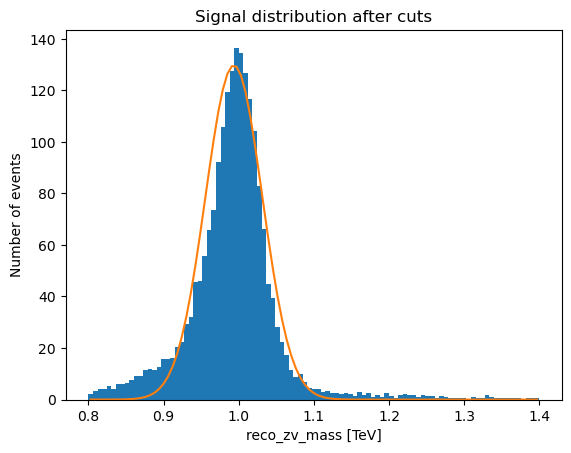

In [123]:
# Overlaying the fitted curve over the original distribution
plt.hist(signal_cut_NN[var_names[-1]]/1e6,bins=np.linspace(0.8,1.4,100),weights=signal_cut_NN.FullEventWeight)
plt.plot(bin_centres, n_events*bin_width*gauss_PDF(bin_centres,mean_NN,sigma_NN))
plt.title("Signal distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

Gaussian wider than signal peak since signal peak has extended tails.

### Fitting signal+background distribution

Updating the number of events to the total distribution.

In [124]:
n_events = total_obs_NN[0].sum()

Fixing the signal Gaussian mean and sigma from the fits based on the NN classified events.

In [125]:
mean = mean_NN

In [126]:
sigma = sigma_NN

Calculating the number of classified signal+background events and their standard deviation using their weights

In [127]:
n_observed = []
sigma_sq = []
for i in range(99):
    # Determine the weights for each bin separately
    mask = ((combined_cut_NN["reco_zv_mass"]/1e6)>bins[i])*((combined_cut_NN["reco_zv_mass"]/1e6)<bins[i+1])
    weights = combined_cut_NN.FullEventWeight[mask]
    
    n_observed.append(np.sum(weights.values))
    sigma_sq.append(np.sum(weights.values**2))

#### H0 hypothesis test

Fitting assuming no signal.

In [128]:
# Set the minimisation parameters
m = Minuit(chisq_poly, a=10,b=1,c=0.1)

# Set the errors on the initial start values
m.errors=[0.1,0.1,0.1]

# Set the increase in Chi squared for the 1-SD error calculation
m.errordef=1.0

# Run the minimisation
m = m.migrad()

In [129]:
# Printing the final results and their error
fstr = "{0:2.4f}"
poly_a = m.values["a"]
poly_a_err = m.errors["a"]
poly_b = m.values["b"]
poly_b_err = m.errors["b"]
poly_c = m.values["c"]
poly_c_err = m.errors["c"]

print("{:2s}".format("a"), "=  ", fstr.format(poly_a), " +/- ", fstr.format(poly_a_err))
print("{:2s}".format("b"), "=  ", fstr.format(poly_b), " +/- ", fstr.format(poly_b_err))
print("{:2s}".format("c"), "=  ", fstr.format(poly_c), " +/- ", fstr.format(poly_c_err))

a  =   4.2750  +/-  0.2272
b  =   -4.7544  +/-  0.2399
c  =   1.3637  +/-  0.0823


<!-- The low uncertainties in the background fit with the polynomial function shows that there is little distortion of the background in the signal region and hence no sign of background sculpting. This can allow us to be confident in the chi-squared values that we obtain from the fit. -->

The values which have been fit show small uncertainties, therefore the minimizer has achieved a good fit to the data. The good fit means we can be confident in the chi-squared value achieved for the H0 hypothesis. 

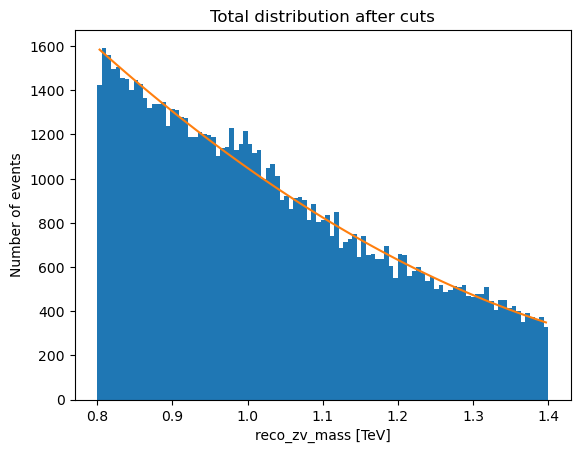

In [130]:
# Overlaying the fitted curve over the original distribution
plt.hist(combined_cut_NN[var_names[-1]]/1e6,bins=np.linspace(0.8,1.4,100),weights=combined_cut_NN.FullEventWeight)
plt.plot(bin_centres, n_events*bin_width*poly_PDF(bin_centres,poly_a,poly_b,poly_c))
plt.title("Total distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

In [131]:
# Calculating the chi_squared value for the final fit
H0_chi_squared_NN = chisq_poly(poly_a,poly_b,poly_c)

In [132]:
print("The chi-squared value from the background-only fit (H0) is:",round(H0_chi_squared_NN,4))

The chi-squared value from the background-only fit (H0) is: 144.5529


#### H1 hypothesis test

Fitting assuming a signal is present in the background.

In [133]:
# Set the minimisation parameters
m = Minuit(chisq_combined, a=10,b=1,c=0.1,F=0.01)
m.limits["F"] = (0,1) 

# Set the errors on the initial start values
m.errors=[0.1,0.1,0.1,0.1]

# Set the increase in Chi squared for the 1-SD error calculation
m.errordef=1.0

# Run the minimisation
m = m.migrad()

In [134]:
# Printing the final results and their error
fstr = "{0:2.4f}"
comb_a_NN = m.values["a"]
comb_a_NN_err = m.errors["a"]
comb_b_NN = m.values["b"]
comb_b_NN_err = m.errors["b"]
comb_c_NN = m.values["c"]
comb_c_NN_err = m.errors["c"]
comb_F_NN = m.values["F"]
comb_F_NN_err = m.errors["F"]

print("{:2s}".format("a"), "=  ", fstr.format(comb_a_NN), " +/- ", fstr.format(comb_a_NN_err))
print("{:2s}".format("b"), "=  ", fstr.format(comb_b_NN), " +/- ", fstr.format(comb_b_NN_err))
print("{:2s}".format("c"), "=  ", fstr.format(comb_c_NN), " +/- ", fstr.format(comb_c_NN_err))
print("{:2s}".format("F"), "=  ", fstr.format(comb_F_NN), " +/- ", fstr.format(comb_F_NN_err))

a  =   4.1616  +/-  0.2321
b  =   -4.7948  +/-  0.2563
c  =   1.4488  +/-  0.0873
F  =   0.0213  +/-  0.0029


The low uncertainties in the background fit with the polynomial function shows that there is little distortion of the background in the signal region and hence no sign of background sculpting. This can allow us to be confident in the chi-squared values that we obtain from the combined fit with the H1 hypothesis.

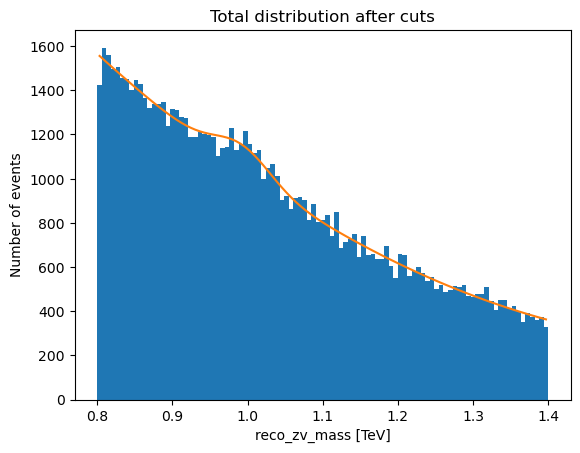

In [135]:
# Overlaying the fitted curve over the original distribution
plt.hist(combined_cut_NN[var_names[-1]]/1e6,bins=np.linspace(0.8,1.4,100),weights=combined_cut_NN.FullEventWeight)
plt.plot(bin_centres, n_events*bin_width*((1-comb_F_NN)*poly_PDF(bin_centres,comb_a_NN,comb_b_NN,comb_c_NN)+comb_F_NN*gauss_PDF(bin_centres,mean,sigma)))
plt.title("Total distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

The signal bump can now clearly be seen in the combined fit around 1 TeV.

In [136]:
# Calculating the chi_squared value for the final fit
H1_chi_squared_NN = chisq_combined(comb_a_NN,comb_b_NN,comb_c_NN,comb_F_NN)

In [137]:
chi_sq_diff = H0_chi_squared_NN-H1_chi_squared_NN

In [138]:
print("The chi-squared difference between H0 and H1 is:",round(chi_sq_diff,4))

The chi-squared difference between H0 and H1 is: 53.2421


In [139]:
pvalue = 1 - scipy.stats.chi2.cdf(chi_sq_diff,1) 
print("The p-value is: ",pvalue)

The p-value is:  2.948752353404416e-13


chi_sq_diff is very large between the H0 and H1 hypotheses and the p-value becomes very small.

### Finding the Z-score

In [140]:
n_sigmas = erfinv(1 - pvalue )* np.sqrt(2)
print("The Z-score is: ",n_sigmas)

The Z-score is:  7.29671648360605


The Z-score achieved by the NN is approx. 2 sigma greater than the Z-score achieved with just the manual cuts alone. This shows that the neural network has been able to create a significant reduction in the background events while retaining a high signal efficiency. This has allowed the chi-squared difference between the H0 and H1 hypotheses to increase and hence provide stronger evidence for the presence of the signal. Given the low H0 and H1 fit uncertainties and no visible background sculpting, we can confidently claim that we have found a signal as we have 7 sigma significance.

## 4. Impact of training sample on classifier (10%)

Now including the <b>reco_zv_mass</b> variable in training of the NN. The events after the manual cuts are used, correspoing to the same events used in the previous neural network training.

In [141]:
select_training = training_data[np.append(var_names,"isSignal")]

Still removing the same highly correlated variables, to just test the difference the addition of <b>reco_zv_mass</b> makes.

In [142]:
select_training = select_training.drop(["Zll_pt","lep1_pt","fatjet_pt","lep2_pt"], axis=1)

In [143]:
features = select_training[select_training.columns[:-1]]
target = select_training.isSignal

Standardising and splitting entries into training and testing sets.

In [144]:
sc = preprocessing.StandardScaler()
features = sc.fit_transform(features)
# set random seed
Answer_to_all_questions = 42
# train - test split of dataset
x_train, x_test, y_train, y_test = model_selection.train_test_split(features, target, test_size=0.2,
                                                                    random_state = Answer_to_all_questions)
print (x_train.shape, x_test.shape, y_train.shape,y_test.shape)

(53214, 5) (13304, 5) (53214,) (13304,)


Repeating the training with the same neural network architecture and training hyperparameters

In [145]:
num_nodes = 30
extra_depth = 1
drop_out = 0.1
model = my_model(x_train.shape[1],num_nodes,extra_depth,drop_out)

In [146]:
batchSize = 512
N_epochs = 50

In [147]:
history = model.fit(x_train,y_train,batch_size=batchSize,epochs=N_epochs,verbose=1,
                    validation_data=(x_test,y_test))

Epoch 1/50
104/104 [==============================] - 1s 4ms/step - loss: 0.4555 - accuracy: 0.9178 - val_loss: 0.1908 - val_accuracy: 0.9561
Epoch 2/50
104/104 [==============================] - 0s 3ms/step - loss: 0.1677 - accuracy: 0.9581 - val_loss: 0.1522 - val_accuracy: 0.9597
Epoch 3/50
104/104 [==============================] - 0s 3ms/step - loss: 0.1532 - accuracy: 0.9605 - val_loss: 0.1461 - val_accuracy: 0.9605
Epoch 4/50
104/104 [==============================] - 0s 3ms/step - loss: 0.1483 - accuracy: 0.9601 - val_loss: 0.1411 - val_accuracy: 0.9609
Epoch 5/50
104/104 [==============================] - 0s 3ms/step - loss: 0.1456 - accuracy: 0.9609 - val_loss: 0.1369 - val_accuracy: 0.9617
Epoch 6/50
104/104 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.9609 - val_loss: 0.1328 - val_accuracy: 0.9614
Epoch 7/50
104/104 [==============================] - 0s 3ms/step - loss: 0.1369 - accuracy: 0.9614 - val_loss: 0.1286 - val_accuracy: 0.9610
Epoch 

Plotting the loss and accuracy curves from the training of the NN.

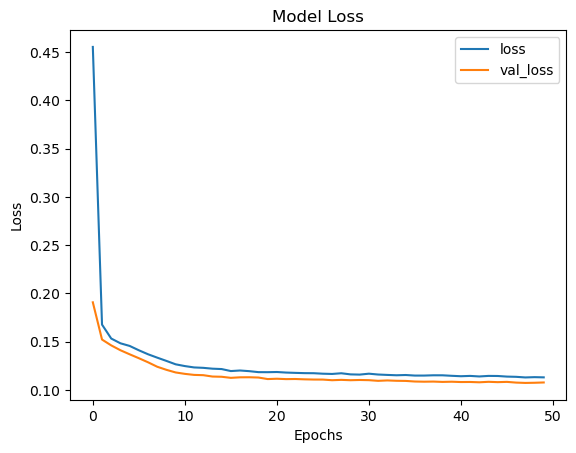

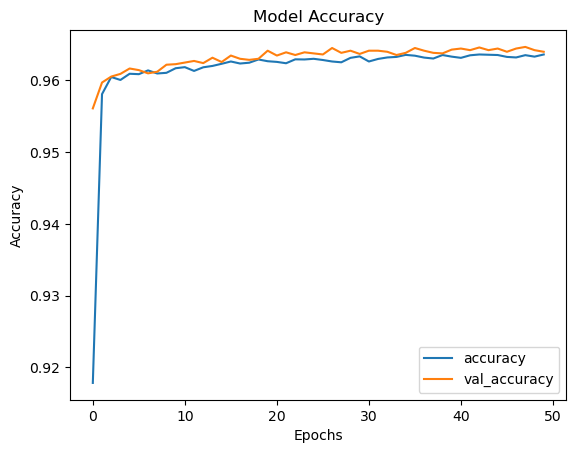

In [148]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["loss","val_loss"])
plt.show()

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["accuracy","val_accuracy"])
plt.show()

The neural network can now achieve a really high accuracy through using the very good signal and background separation in the reco_zv_mass variable.

Loss curves are constantly decreasing showing improvement with each epoch and no sign of overfitting.

The accuracy curves are consistently increasing and show good training.

In [149]:
combined_test_cut = combined_cut[np.append(var_names,"isSignal")]

In [150]:
combined_test_cut = combined_test_cut.drop(["Zll_pt","lep1_pt","fatjet_pt","lep2_pt"], axis=1)

In [151]:
features_test_cut = combined_test_cut[combined_test_cut.columns[:-1]]
combined_target_cut = combined_test_cut.isSignal

Standardising the testing features.

In [152]:
sc = preprocessing.StandardScaler()
features_test_cut = sc.fit_transform(features_test_cut)

In [153]:
print("Number of testing entries: ",features_test_cut.shape[0])

Number of testing entries:  666077


Determining the scores the network gives to each entry and then plotting the scores separately for signal and background.

In [154]:
score = model.predict(features_test_cut)

20815/20815 [==============================] - 13s 635us/step


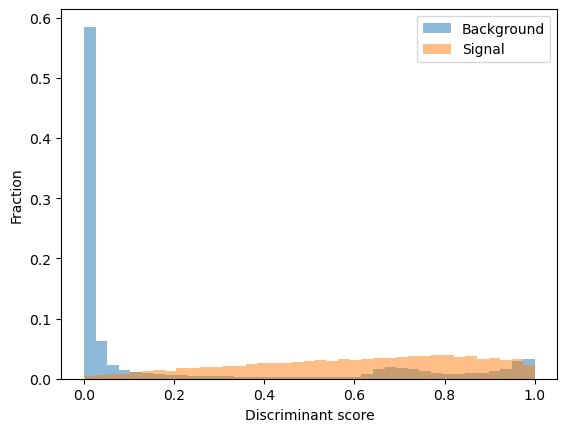

In [155]:
plot_score(score)

The network has become much more confident in the background events compared to before training with the <b>reco_zv_mass</b> variable. However, the discriminant score for the signal has also become more spread out, meaning the network has become less confident in the signal.

In [156]:
prediction = score>0.5 # Events with score>0.5 are predicted as signal

Creating a confusion matrix for the inclusive <b>reco_zv_mass</b> region.

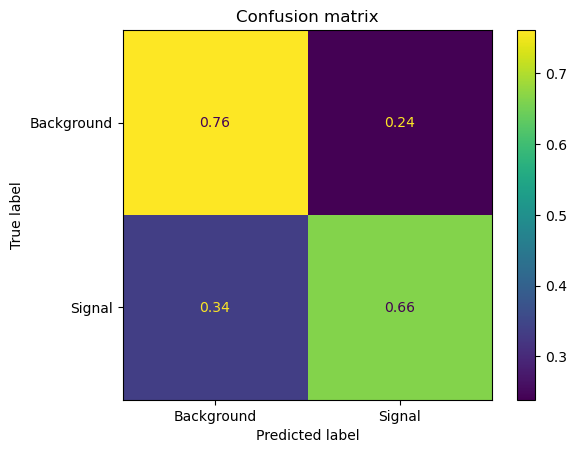

In [157]:
cm = confusion_matrix(combined_target_cut,prediction,normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Background","Signal"])

disp.plot()
plt.title("Confusion matrix")
plt.show()

From the confusion matrix we can see that both the fraction of signal and background retained has gone down compared to the previous NN results. The background has reduced by a larger fraction compared to the signal which is a good sign.

Creating a separate dataframe with the entries which pass the NN classification. 

In [158]:
combined_cut_NN = combined_cut[prediction.flatten()]

Creating separate signal and background dataframes.

In [159]:
signal_cut_NN = combined_cut_NN[combined_cut_NN.isSignal==1]
background_cut_NN = combined_cut_NN[combined_cut_NN.isSignal==0]

Making plots for the weighted signal, background and combined distributions inside the 0.8 to 1.4 TeV signal region and saving their bins and bin counts.

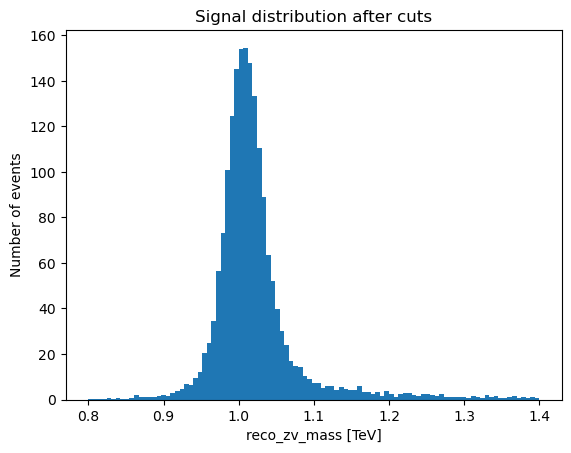

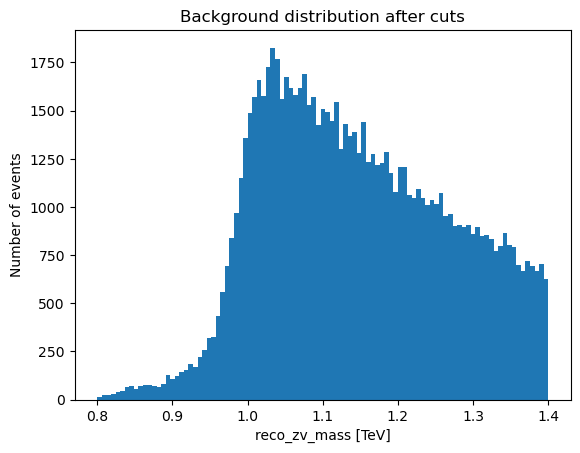

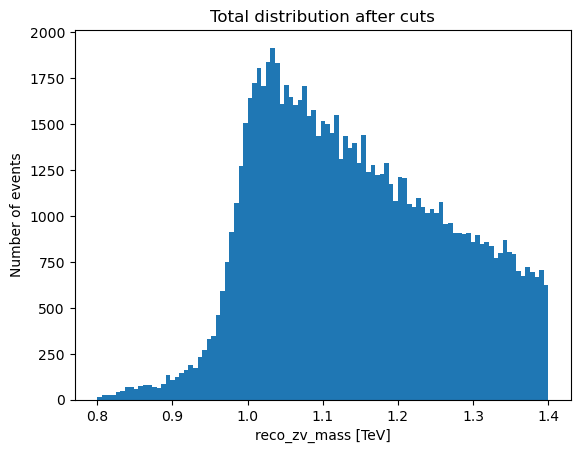

In [160]:
signal_obs_NN = plt.hist(signal_cut_NN[var_names[-1]]/1e6,bins=np.linspace(0.8,1.4,100),weights=signal_cut_NN.FullEventWeight)
plt.title("Signal distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

back_obs_NN = plt.hist(background_cut_NN[var_names[-1]]/1e6,bins=np.linspace(0.8,1.4,100),weights=background_cut_NN.FullEventWeight)
plt.title("Background distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

total_obs_NN = plt.hist(combined_cut_NN[var_names[-1]]/1e6,bins=np.linspace(0.8,1.4,100),weights=combined_cut_NN.FullEventWeight)
plt.title("Total distribution after cuts")
plt.xlabel("reco_zv_mass [TeV]")
plt.ylabel("Number of events")
plt.show()

The signal distribution has been slightly morphed to look more symmetrical (looks more Gaussian) and the number of accepted signal events has slightly decreased compared to training without the <b>reco_zv_mass</b> variable.

However, the background distribution has been significantly distorted (sculpted) as compared to the previous neural network classification. The background is no longer a continuously falling distribution which can be modelled by a polynomial curve. Furthermore, the background accepted has become peaked which can mislead us to believe the signal is found at a different mass. 

The vast majority of the background has been rejected below the signal mass.

In [161]:
print("Total background events after classification (signal region):",back_obs_NN[0].sum())
print("Total signal events after classification (signal region):",signal_obs_NN[0].sum())

Total background events after classification (signal region): 86924.24692771869
Total signal events after classification (signal region): 1834.2000817847656


In [162]:
print("Fraction of background passing classification (signal region):",\
      back_obs_NN[0].sum()/background_cut.FullEventWeight[sig_reg_bkg_cut].sum())
print("Fraction of signal passing classification (signal region):",\
      signal_obs_NN[0].sum()/signal_cut.FullEventWeight[sig_reg_sig_cut].sum())

Fraction of background passing classification (signal region): 0.5371058937795258
Fraction of signal passing classification (signal region): 0.671698451045679


The total number of background events in the signal region was reduced by approx. 46% while the number of signal events was reduced by approx. 33%. This shows more background was accepted in the signal region and less signal was retained compared to training without the <b>reco_zv_mass</b> variable.

In [163]:
sensitivity_NN = signal_obs_NN[0].sum()/np.sqrt(back_obs_NN[0].sum())
print("The sensitivty achieved by training with reco_zv_mass is:",sensitivity_NN)

The sensitivty achieved by training with reco_zv_mass is: 6.221229748866412


The sensitivity without training with reco_zv_mass was approx. 7.0. Therefore, by including the reco_zv_mass variable in training the sensitivity of the neural network classification has gone down. We can consider why this happens. Although the reco_zv_mass variable has a good signal and background separation which allows the classifier to achieve high accuracy, training with this variable makes the classification become biased. 

The background is no longer reduced uniformly across the full reco_zv_mass range, but instead it gets preferentially accepted into the signal region. So even though the background is significantly reduced, it mainly gets reduced in the region which we are not interested in. This causes a number of problems. Firstly, this can mislead us to believe that we have accepted more signal than we actually have, and secondly, the background fit is no longer possible due to the high sculpting. This creates uncertainties in the fit of the background and therefore we cannot test our H0 and H1 hypotheses anymore. 

To avoid this problem we need to make cuts on variables with low reco_zv_mass correlation. In the training of the NN this means only using variables which have low correlation with reco_zv_mass. If cuts are made on highly correlated variables with reco_zv_mass, or reco_zv_mass itself, then significant background sculpting will take place. 